In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [3]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [4]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [5]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

# Load data

In [6]:
# Data = pd.read_hdf(os.path.join(features_path,'Features_HP+LP.h5'))
# print(Data.shape)
# Data.head(2)

In [7]:
# filename = 'Features_AllLocsBP.pkl'
# filename = 'Features_AllLocsHP.pkl'
filename = 'Features_AllLocsHP+LP.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(48579, 13)


In [8]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,dorsal_hand__accel,dorsal_hand__gyro,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.014046611028, 0.0206034517749, 0.0077429206...","[10.2735064283, 2.70628321634, 5.06156027666, ...","[0.00798993081331, 0.00961279888663, 0.0067765...","[2.76357718659, 1.92269058745, 4.20092382287, ...","[0.00287056120312, 0.0113620696337, 0.00565619...","[0.821561465605, 1.12651785292, 0.664853976891..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0127849757898, 0.0198152867228, 0.007881728...","[10.6623947259, 2.62870322658, 4.46563354233, ...","[0.00769283813801, 0.00921030318617, 0.0066355...","[3.3284323758, 2.82269751589, 5.35174212743, 2...","[0.00307376080672, 0.0108096891701, 0.00484014...","[0.78987931307, 3.34563757752, 0.72237941082, ..."


#### This section reconciles the following - Load features, merge with metadata from raw datafiles, and resave as pkl file

In [801]:
# filename = 'Features_AllLocsUnfiltered.pkl'
# Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Data = Data.reset_index(drop=True)
# print(Data.shape)
# metadata = pickle.load(open(os.path.join(features_path,'DataRaw_AllLocsUnfiltered.pkl'),'rb'))
# metadata=metadata.reset_index(drop=True)
# metadata = metadata.iloc[:,:7]
# print(metadata.shape)
# print(Data.shape)
# #concatenates metadata
# Data=pd.concat((metadata,Data),axis=1)
# #save features pkl file
# f = open(os.path.join(features_path,filename),'wb')
# pickle.dump(Data,f)
# f.close()

### Filter empty rows on  hand sensors only and unpack features and save

Filter on all locations 

In [864]:
# #filter empty rows on all locations
# for s in Data.columns.values[7:]:
#     print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
#     Data = Data[Data[s].apply(type) != float]

Filter on hand only

In [877]:
#filter empty rows (no features available) on hand sensors
print('discarded %d rows'%(len(Data[Data.dorsal_hand__accel.apply(type) == float])))
Data = Data[Data.dorsal_hand__accel.apply(type) != float]
print('discarded %d rows'%(len(Data[Data.dorsal_hand__gyro.apply(type) == float])))
Data = Data[Data.dorsal_hand__gyro.apply(type) != float]

discarded 6479 rows
discarded 0 rows


In [878]:
Data.shape

(42100, 13)

In [879]:
#unpack features
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

colnames1=[i+'acc' for i in colnames]
colnames2=[i+'gyr' for i in colnames]
colnames=colnames1+colnames2

In [880]:
Datanew = pd.DataFrame(columns=colnames)
for i in range(len(Data)):
    F1 = Data.dorsal_hand__accel.iloc[i]
    F2 = Data.dorsal_hand__gyro.iloc[i]
    F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=colnames)
    Datanew=pd.concat((Datanew,F),axis=0)

In [881]:
Datanew.head(2)

,RMSXacc,RMSYacc,RMSZacc,rangeXacc,rangeYacc,rangeZacc,meanXacc,meanYacc,meanZacc,varXacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,0.007990,0.009613,0.006777,0.599504,0.744752,0.483158,-0.002406,0.007534,0.003762,0.141336,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,0.007693,0.009210,0.006636,0.535280,0.693556,0.445568,0.009642,-0.000565,0.003741,0.135758,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [882]:
Datanew=Datanew.reset_index(drop=True)
Data=Data.reset_index(drop=True)

In [883]:
Data = pd.concat((Data.iloc[:,:7],Datanew),axis=1)

In [884]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007990,0.009613,0.006777,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007693,0.009210,0.006636,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [885]:
filename

'Features_AllLocsHP+LP.pkl'

In [886]:
saved_filename = filename[:-4] + '_Hand.pkl'
print(saved_filename)
# #save features pkl file
f = open(os.path.join(features_path,saved_filename),'wb')
pickle.dump(Data,f)
f.close()

Features_AllLocsHP+LP_Hand.pkl


## Load unpacked features data

In [9]:
filename = 'Features_AllLocsHP+LP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [10]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007990,0.009613,0.006777,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007693,0.009210,0.006636,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [11]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [12]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [13]:
Data.shape

(40377, 63)

In [14]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

# ALL TASKS


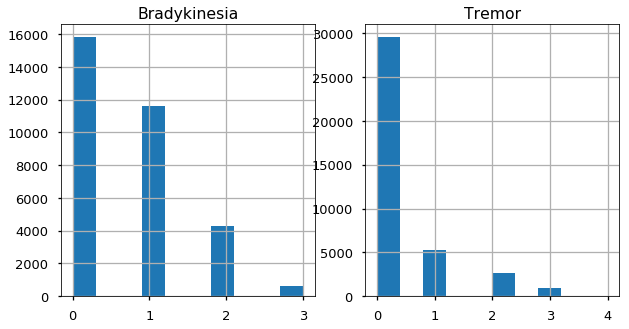

In [15]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x11200c4a8>, <matplotlib.text.Text at 0x1221b2e80>)

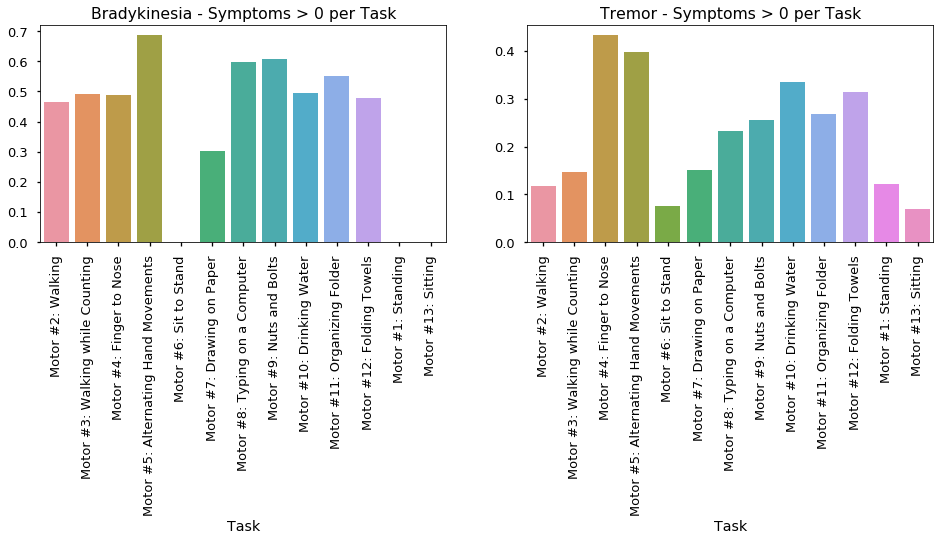

In [16]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

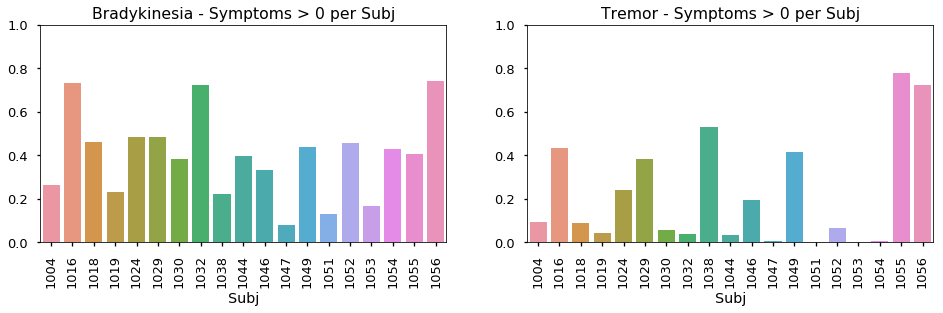

In [17]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

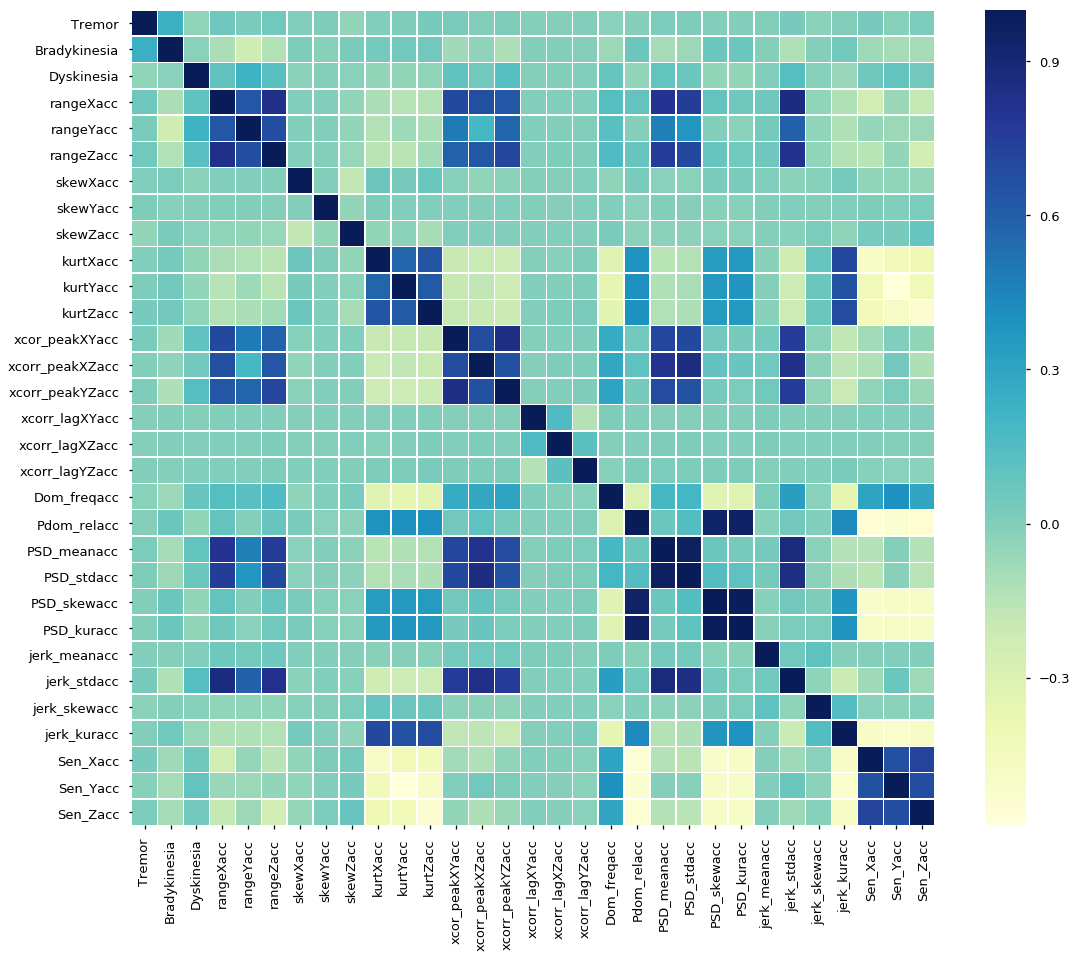

In [76]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

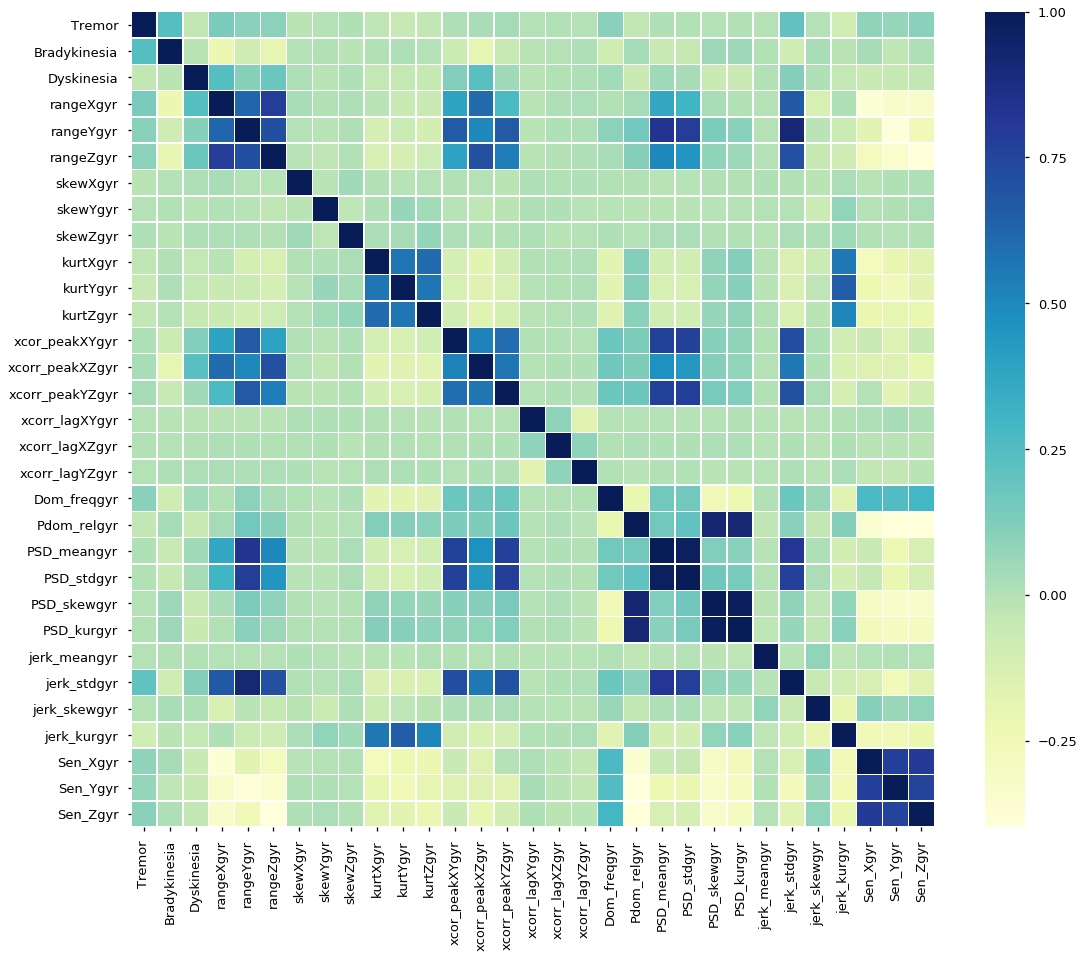

In [77]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## LOSO CV - ALL TASKS

In [30]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [78]:
t1=time.time()
res_all = pd.DataFrame()

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/40377 = 0.41
Training Random Forest

Subj/Visit 0, prec=0.551, rec=0.492, Spec=0.857, auroc_train=1.000, auroc=0.793

Subj/Visit 1, prec=0.913, rec=0.668, Spec=0.826, auroc_train=1.000, auroc=0.847

Subj/Visit 2, prec=0.770, rec=0.629, Spec=0.839, auroc_train=1.000, auroc=0.832

Subj/Visit 3, prec=0.507, rec=0.858, Spec=0.748, auroc_train=1.000, auroc=0.885

Subj/Visit 4, prec=0.754, rec=0.518, Spec=0.840, auroc_train=1.000, auroc=0.774

Subj/Visit 5, prec=0.594, rec=0.581, Spec=0.630, auroc_train=1.000, auroc=0.639

Subj/Visit 6, prec=0.654, rec=0.723, Spec=0.764, auroc_train=1.000, auroc=0.839

Subj/Visit 7, prec=0.848, rec=0.446, Spec=0.789, auroc_train=1.000, auroc=0.754

Subj/Visit 8, prec=0.320, rec=0.454, Spec=0.722, auroc_train=1.000, auroc=0.653

Subj/Visit 9, prec=0.660, rec=0.710, Spec=0.759, auroc_train=1.000, auroc=0.813

Subj/Visit 10, prec=0.645, rec=0.476, Spec=0.870, auroc_train=1.000, auroc=0.781

Subj/Visit 11, prec=0.231, rec=0.482, Spec=0.

In [79]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

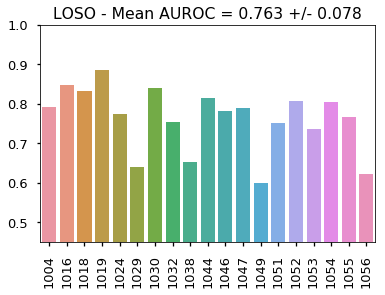

In [130]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

### Feature importance

In [131]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

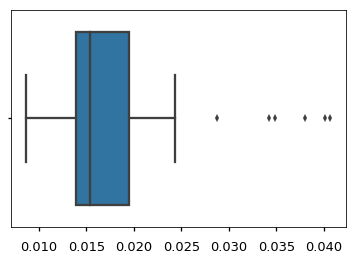

In [132]:
ax=sns.boxplot(meanfi)

In [133]:
fnames = Data.iloc[:,7:].columns.values


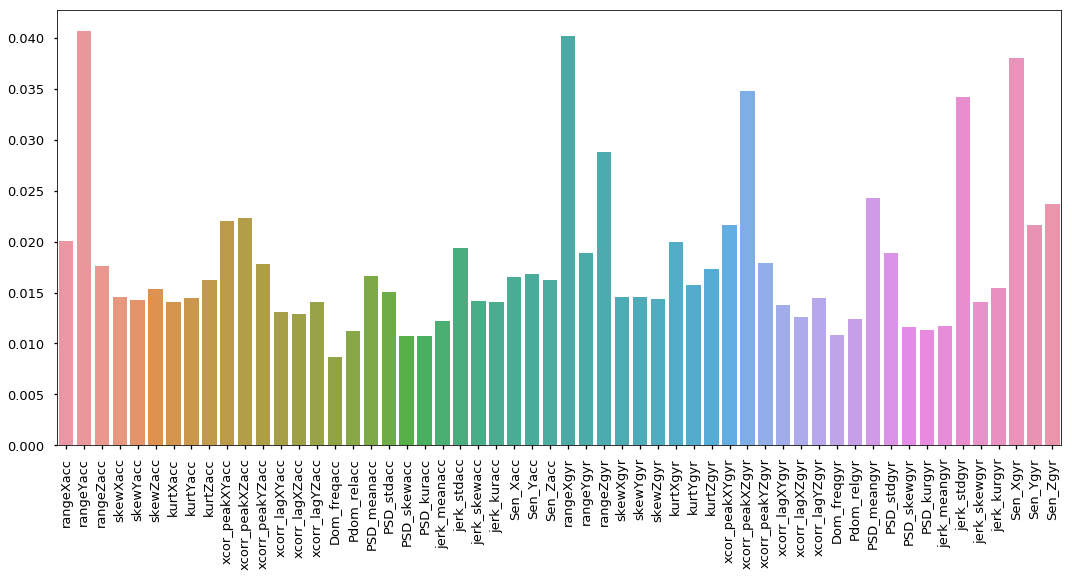

In [135]:
plt.figure(figsize=(18,8))
sns.barplot(x=np.arange(len(meanfi)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(meanfi)),fnames,rotation=90)

In [136]:
np.percentile(meanfi,75)

0.019497235513173138

In [137]:
sum(meanfi>0.02)

13

In [146]:
#top features
n = 13
fnames[np.argsort(meanfi)[::-1]][:n]

array(['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
       'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
       'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
       'rangeXacc'], dtype=object)

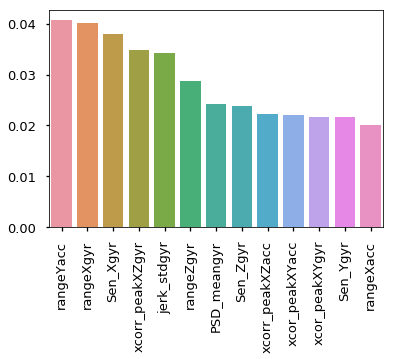

In [147]:
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames[np.argsort(meanfi)[::-1]][:n],rotation=90)

In [152]:
t1=time.time()
res_all = pd.DataFrame()

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))
    
    #top features
    n = 13
    topf = fnames[np.argsort(meanfi)[::-1]][:n]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/40377 = 0.41
Training Random Forest

Subj/Visit 0, prec=0.575, rec=0.548, Spec=0.855, auroc_train=1.000, auroc=0.789

Subj/Visit 1, prec=0.909, rec=0.657, Spec=0.821, auroc_train=1.000, auroc=0.838

Subj/Visit 2, prec=0.720, rec=0.588, Spec=0.805, auroc_train=1.000, auroc=0.797

Subj/Visit 3, prec=0.476, rec=0.850, Spec=0.716, auroc_train=1.000, auroc=0.861

Subj/Visit 4, prec=0.705, rec=0.509, Spec=0.798, auroc_train=1.000, auroc=0.739

Subj/Visit 5, prec=0.587, rec=0.561, Spec=0.633, auroc_train=1.000, auroc=0.634

Subj/Visit 6, prec=0.660, rec=0.712, Spec=0.774, auroc_train=1.000, auroc=0.837

Subj/Visit 7, prec=0.836, rec=0.474, Spec=0.756, auroc_train=1.000, auroc=0.744

Subj/Visit 8, prec=0.325, rec=0.467, Spec=0.721, auroc_train=1.000, auroc=0.672

Subj/Visit 9, prec=0.651, rec=0.696, Spec=0.754, auroc_train=1.000, auroc=0.810

Subj/Visit 10, prec=0.600, rec=0.570, Spec=0.812, auroc_train=1.000, auroc=0.775

Subj/Visit 11, prec=0.194, rec=0.532, Spec=0.

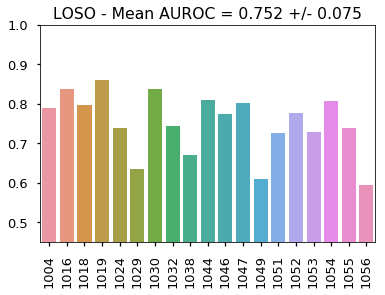

In [153]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Personal Models

In [19]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.797, rec=0.210, Spec=0.840, auroc_train=1.000, auroc=0.784

Subj/Visit 1, prec=0.303, rec=0.286, Spec=0.903, auroc_train=1.000, auroc=0.711

Subj/Visit 2, prec=0.708, rec=0.708, Spec=0.973, auroc_train=1.000, auroc=0.973

Subj/Visit 3, prec=0.618, rec=0.632, Spec=0.834, auroc_train=1.000, auroc=0.834

Subj/Visit 4, prec=0.404, rec=0.731, Spec=0.887, auroc_train=1.000, auroc=0.918

Subj/Visit 5, prec=0.875, rec=0.457, Spec=0.987, auroc_train=1.000, auroc=0.911

Subj/Visit 6, prec=0.616, rec=0.608, Spec=0.883, auroc_train=1.000, auroc=0.854
f1_test=0.527+/-0.145, prec=0.617+/-0.189, rec=0.519+/-0.191, auprc=0.605+/-0.202, auroc=0.855+/-0.082
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.939, rec=0.928, Spec=0.826, auroc_train=1.000, auroc=0.963

Subj/Visit 1, prec=0.837, rec=0.979, Spec=0.511, auroc_train=1.000, auroc=0.913

Subj/Visit 2, prec=0.835, rec=0.977, Spec=0.543, auroc_train=1.000, auroc=0.934

Subj/Visit 3, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.444, Spec=1.000, auroc_train=1.000, auroc=0.836


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.162+/-0.257, prec=0.276+/-0.437, rec=0.115+/-0.183, auprc=0.753+/-0.014, auroc=0.841+/-0.005
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.741, rec=0.488, Spec=0.865, auroc_train=1.000, auroc=0.792

Subj/Visit 1, prec=0.820, rec=0.773, Spec=0.867, auroc_train=1.000, auroc=0.875

Subj/Visit 2, prec=0.836, rec=0.772, Spec=0.874, auroc_train=1.000, auroc=0.907

Subj/Visit 3, prec=0.896, rec=0.548, Spec=0.949, auroc_train=1.000, auroc=0.893

Subj/Visit 4, prec=0.840, rec=0.792, Spec=0.877, auroc_train=1.000, auroc=0.911

Subj/Visit 5, prec=0.810, rec=0.667, Spec=0.874, auroc_train=1.000, auroc=0.870

Subj/Visit 6, prec=0.421, rec=0.475, Spec=0.580, auroc_train=1.000, auroc=0.513
f1_test=0.694+/-0.126, prec=0.766+/-0.147, rec=0.645+/-0.130, auprc=0.797+/-0.150, auroc=0.823+/-0.132
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.8

In [20]:
#compute mean and std auc
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

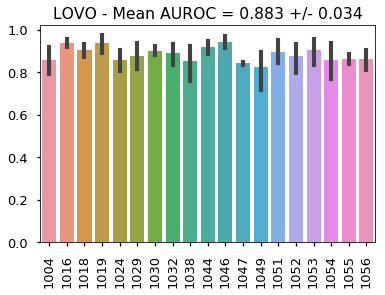

In [30]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))

# Subgroup of tasks (4)

In [10]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Bradykinesia 1882/3337 = 0.56
Training Random Forest

Subj/Visit 0, prec=0.923, rec=0.228, Spec=0.981, auroc_train=1.000, auroc=0.647

Subj/Visit 1, prec=0.625, rec=0.874, Spec=0.053, auroc_train=1.000, auroc=0.253

Subj/Visit 2, prec=0.707, rec=0.990, Spec=0.339, auroc_train=1.000, auroc=0.815

Subj/Visit 3, prec=0.738, rec=0.775, Spec=0.756, auroc_train=1.000, auroc=0.851

Subj/Visit 4, prec=0.057, rec=1.000, Spec=0.336, auroc_train=1.000, auroc=0.945

Subj/Visit 5, prec=0.953, rec=0.820, Spec=0.500, auroc_train=1.000, auroc=0.747

Subj/Visit 6, prec=0.522, rec=0.734, Spec=0.594, auroc_train=1.000, auroc=0.666

Subj/Visit 7, prec=0.793, rec=0.884, Spec=0.509, auroc_train=1.000, auroc=0.799
only 1 class in test data - cannot compute roc curve

Subj/Visit 8, prec=1.000, rec=0.984, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 9, prec=0.607, rec=0.796, Spec=0.407, auroc_train=1.000, auroc=0.690

Subj/Visit 10, prec=0.458, rec=1.000, Spec=0.294, auroc_train=1.000, auroc=0.656

Subj/Visit 11, prec=0.733, rec=0.808, Spec=0.720, auroc_train=1.000, auroc=0.839

Subj/Visit 12, prec=0.319, rec=1.000, Spec=0.620, auroc_train=1.000, auroc=0.898
only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 14, prec=0.741, rec=0.364, Spec=0.931, auroc_train=1.000, auroc=0.713

Subj/Visit 15, prec=0.800, rec=0.706, Spec=0.860, auroc_train=1.000, auroc=0.848

Subj/Visit 16, prec=0.150, rec=0.250, Spec=0.490, auroc_train=1.000, auroc=0.328

Subj/Visit 17, prec=0.839, rec=0.743, Spec=0.821, auroc_train=1.000, auroc=0.887

Subj/Visit 18, prec=0.867, rec=0.459, Spec=0.872, auroc_train=1.000, auroc=0.656
only 1 class in test data - cannot compute roc curve

Subj/Visit 19, prec=1.000, rec=0.727, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.666+/-0.234, prec=0.692+/-0.266, rec=0.757+/-0.241, auprc=0.720+/-0.228

 ['Motor #2: Walking' 'Motor #3: Walking while Counting']


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


Rows w Bradykinesia 3290/7079 = 0.46
Training Random Forest

Subj/Visit 0, prec=0.813, rec=0.718, Spec=0.929, auroc_train=1.000, auroc=0.840

Subj/Visit 1, prec=0.965, rec=0.893, Spec=0.000, auroc_train=1.000, auroc=0.499

Subj/Visit 2, prec=0.847, rec=1.000, Spec=0.819, auroc_train=1.000, auroc=0.980

Subj/Visit 3, prec=1.000, rec=0.950, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.145, rec=0.580, Spec=0.310, auroc_train=1.000, auroc=0.491

Subj/Visit 5, prec=0.283, rec=1.000, Spec=0.523, auroc_train=1.000, auroc=0.839

Subj/Visit 6, prec=0.510, rec=0.083, Spec=0.528, auroc_train=1.000, auroc=0.380

Subj/Visit 7, prec=0.910, rec=0.994, Spec=0.916, auroc_train=1.000, auroc=0.974

Subj/Visit 8, prec=0.593, rec=0.774, Spec=0.286, auroc_train=1.000, auroc=0.639

Subj/Visit 9, prec=0.784, rec=0.556, Spec=0.847, auroc_train=1.000, auroc=0.750

Subj/Visit 10, prec=0.915, rec=0.973, Spec=0.909, auroc_train=1.000, auroc=0.978
only 1 class in test data - cannot compute roc c

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 12, prec=0.782, rec=0.827, Spec=0.959, auroc_train=1.000, auroc=0.973

Subj/Visit 13, prec=0.274, rec=0.181, Spec=0.629, auroc_train=1.000, auroc=0.318

Subj/Visit 14, prec=0.603, rec=0.442, Spec=0.915, auroc_train=1.000, auroc=0.811

Subj/Visit 15, prec=0.774, rec=0.644, Spec=0.911, auroc_train=1.000, auroc=0.842

Subj/Visit 16, prec=0.022, rec=0.167, Spec=0.694, auroc_train=1.000, auroc=0.513

Subj/Visit 17, prec=0.927, rec=0.722, Spec=0.945, auroc_train=1.000, auroc=0.884

Subj/Visit 18, prec=0.750, rec=0.062, Spec=0.996, auroc_train=1.000, auroc=0.763

Subj/Visit 19, prec=0.828, rec=0.442, Spec=0.802, auroc_train=1.000, auroc=0.670
f1_test=0.601+/-0.300, prec=0.686+/-0.286, rec=0.623+/-0.310, auprc=0.706+/-0.279

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Bradykinesia 6228/12681 = 0.49
Training Random Forest

Subj/Visit 0, prec=0.575, rec=0.570, Spec=0.849, auroc_train=1.000, auroc=0.812
only 1 class in test data - 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 2, prec=0.765, rec=0.594, Spec=0.608, auroc_train=1.000, auroc=0.622

Subj/Visit 3, prec=0.270, rec=0.872, Spec=0.528, auroc_train=1.000, auroc=0.739

Subj/Visit 4, prec=0.040, rec=0.429, Spec=0.676, auroc_train=1.000, auroc=0.598

Subj/Visit 5, prec=0.772, rec=0.385, Spec=0.811, auroc_train=1.000, auroc=0.646

Subj/Visit 6, prec=0.443, rec=0.793, Spec=0.365, auroc_train=1.000, auroc=0.645

Subj/Visit 7, prec=0.357, rec=0.515, Spec=0.497, auroc_train=1.000, auroc=0.512
only 1 class in test data - cannot compute roc curve

Subj/Visit 8, prec=1.000, rec=0.529, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 9, prec=0.164, rec=0.438, Spec=0.580, auroc_train=1.000, auroc=0.542

Subj/Visit 10, prec=0.600, rec=0.705, Spec=0.603, auroc_train=1.000, auroc=0.705

Subj/Visit 11, prec=0.025, rec=0.091, Spec=0.909, auroc_train=1.000, auroc=0.737

Subj/Visit 12, prec=0.076, rec=0.643, Spec=0.748, auroc_train=1.000, auroc=0.819

Subj/Visit 13, prec=0.480, rec=0.427, Spec=0.538, auroc_train=1.000, auroc=0.476

Subj/Visit 14, prec=0.027, rec=0.364, Spec=0.675, auroc_train=1.000, auroc=0.487

Subj/Visit 15, prec=0.844, rec=0.534, Spec=0.804, auroc_train=1.000, auroc=0.765

Subj/Visit 16, prec=0.079, rec=0.846, Spec=0.647, auroc_train=1.000, auroc=0.768

Subj/Visit 17, prec=0.715, rec=0.617, Spec=0.801, auroc_train=1.000, auroc=0.758

Subj/Visit 18, prec=0.665, rec=0.588, Spec=0.401, auroc_train=1.000, auroc=0.433
only 1 class in test data - cannot compute roc curve

Subj/Visit 19, prec=1.000, rec=0.455, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.447+/-0.236, prec=0.495+/-0.340, rec=0.5

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Bradykinesia 5282/10877 = 0.49
Training Random Forest

Subj/Visit 0, prec=0.463, rec=0.593, Spec=0.693, auroc_train=1.000, auroc=0.682

Subj/Visit 1, prec=1.000, rec=0.780, Spec=1.000, auroc_train=1.000, auroc=0.999

Subj/Visit 2, prec=0.696, rec=0.785, Spec=0.699, auroc_train=1.000, auroc=0.856

Subj/Visit 3, prec=0.443, rec=0.941, Spec=0.626, auroc_train=1.000, auroc=0.890

Subj/Visit 4, prec=0.097, rec=0.641, Spec=0.469, auroc_train=1.000, auroc=0.578

Subj/Visit 5, prec=0.894, rec=0.605, Spec=0.757, auroc_train=1.000, auroc=0.782

Subj/Visit 6, prec=0.938, rec=0.853, Spec=0.814, auroc_train=1.000, auroc=0.904

Subj/Visit 7, prec=0.755, rec=0.745, Spec=0.683, auroc_train=1.000, auroc=0.830

Subj/Visit 8, prec=0.843, rec=0.574, Spec=0.712, auroc_train=1.000, auroc=0.729

Subj/Visit 9, prec=0.228, rec=0.606, Spec=0.438, auroc_train=1.000, auroc=0.567

Subj/Visit 10, prec=0.766, rec=0.7

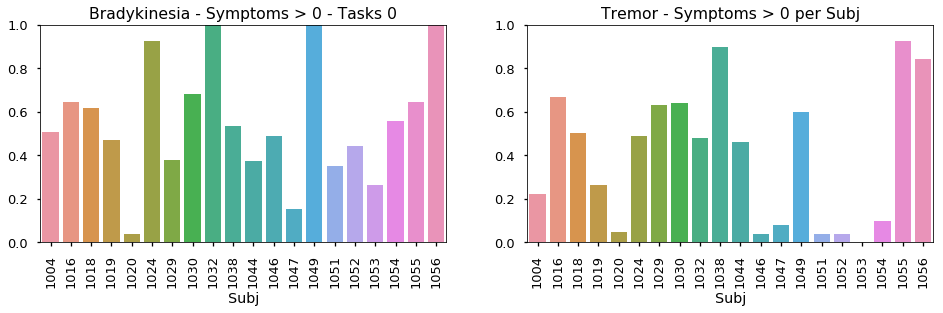

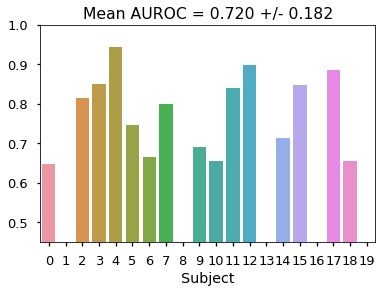

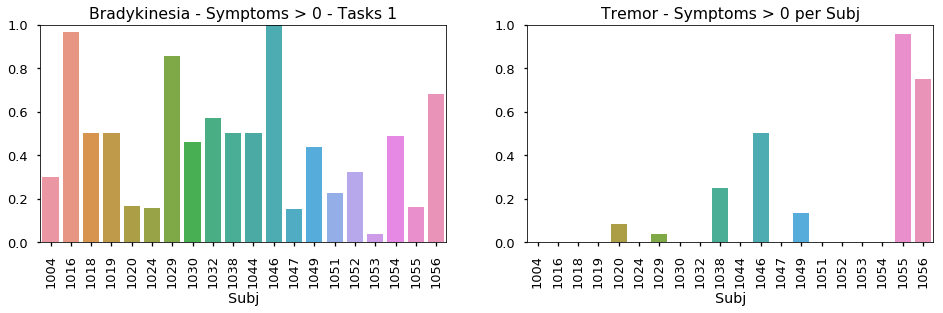

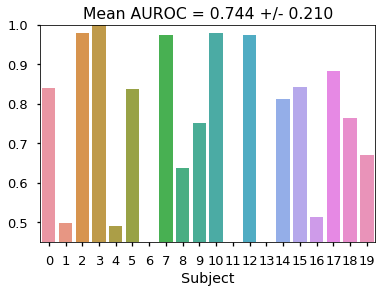

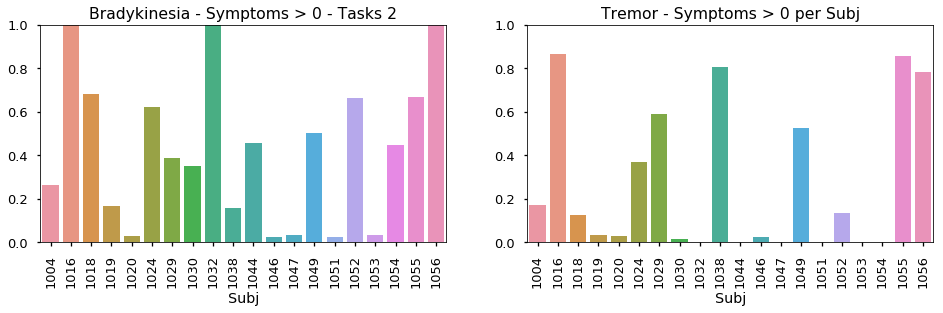

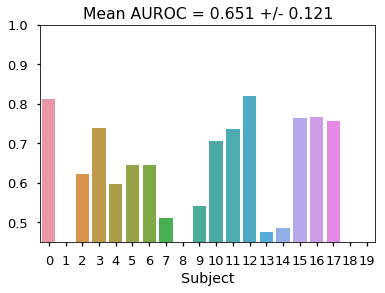

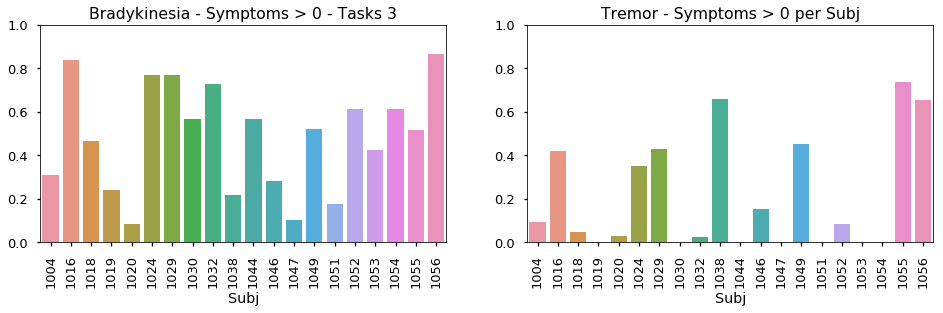

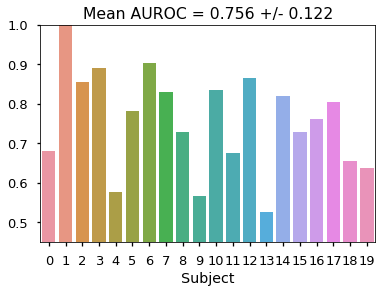

In [13]:
for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on subtasks
    res_all = pd.DataFrame()
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Bradykinesia']:

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))




### Personal models

In [16]:
res_visit_all[i]['Random Forest']['auroc']

[nan, nan, nan, nan, nan, nan]

In [14]:
for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
        
    #train clf on subtasks
    res_all = pd.DataFrame()
    X = Data.iloc[:,7:].as_matrix()
    fnames = Data.iloc[:,7:].columns
    
    res_all = pd.DataFrame(data=None,index=None)
    #train on all sessions, predict on left out session for each patient
    res_visit_all = [] #data from each subject 
    for s in Data.Subject.unique():
        print('Subject %s'%s)
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,7:].as_matrix()
#             X_std = StandardScaler().fit_transform(X) #standardize input data
        models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
        model_name = ['Random Forest']#,'XGB']
        models = list(zip(models,model_name))
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        res,res_group = LOSOCV(ds,X,y,groups,models)
        res.index = res.index+s
        res_all=pd.concat((res_all,res))
        res_visit_all.append(res_group)

    #plot results across subjects
    #compute mean and std auc
    auc_mean = []; auc_std = []
    aucdf = pd.DataFrame()
    for i in range(len(res_visit_all)):
        if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
            res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
        aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
        auc_i = res_visit_all[i]['Random Forest']['auroc']
        auc_mean.append(np.nanmean(auc_i)) #mean across visits
        auc_std.append(np.nanstd(auc_i))
    plt.figure()
    sns.barplot(data=aucdf)
    ax=plt.xticks(rotation=90)
    plt.title('LOVO - Tasks %d'%(i))



 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Subject 1004
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.660, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.077, rec=0.091, Spec=0.657, auroc_train=1.000, auroc=0.655

Subj/Visit 2, prec=0.538, rec=0.583, Spec=0.824, auroc_train=1.000, auroc=0.808

Subj/Visit 3, prec=0.533, rec=0.640, Spec=0.440, auroc_train=1.000, auroc=0.594

Subj/Visit 4, prec=0.520, rec=1.000, Spec=0.676, auroc_train=1.000, auroc=0.728

Subj/Visit 5, prec=0.950, rec=0.792, Spec=0.958, auroc_train=1.000, auroc=0.965
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.565, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.613+/-0.238, prec=0.660+/-0.318, rec=0.619+/-0.256, auprc=0.668+/-0.297
Subject 1016
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.792, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.375, rec=1.000, Spec=0.444, auroc_train=1.000, auroc=0.944

Subj/Visit 2, prec=0.333, rec=1.000, Spec=0.412, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.750, rec=0.900, Spec=0.750, auroc_train=1.000, auroc=0.908
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.542, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.730+/-0.156, prec=0.780+/-0.282, rec=0.814+/-0.183, auprc=0.961+/-0.065
Subject 1018
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.458, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.889, rec=1.000, Spec=0.875, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.455, rec=1.000, Spec=0.647, auroc_train=1.000, auroc=0.906

Subj/Visit 3, prec=0.650, rec=1.000, Spec=0.462, auroc_train=1.000, auroc=0.988

Subj/Visit 4, prec=0.923, rec=1.000, Spec=0.917, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.833, rec=0.833, Spec=0.833, auroc_train=1.000, auroc=0.931
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.778+/-0.131, prec=0.821+/-0.186, rec=0.827+/-0.228, auprc=0.902+/-0.205
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.765, rec=0.684, Spec=0.429, auroc_train=1.000, auroc=0.695

Subj/Visit 1, prec=0.857, rec=1.000, Spec=0.944, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.529, Spec=1.000, auroc_train=1.000, auroc=0.706

Subj/Visit 4, prec=0.917, rec=0.917, Spec=0.917, auroc_train=1.000, auroc=0.965

Subj/Visit 5, prec=0.857, rec=1.000, Spec=0.938, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.923, rec=0.857, Spec=0.929, auroc_train=1.000, auroc=0.982
f1_test=0.867+/-0.106, prec=0.903+/-0.078, rec=0.855+/-0.170, auprc=0.967+/-0.037
Subject 1020
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan
Subject 1024
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.818, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.983+/-0.037, prec=1.000+/-0.000, rec=0.970+/-0.068, auprc=1.000+/-0.000
Subject 1029
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.500, rec=1.000, Spec=0.700, auroc_train=1.000, auroc=0.800

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.500, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.800, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.714, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.751+/-0.322, prec=0.786+/-0.364, rec=0.752+/-0.322, auprc=0.897+/-0.231
Subject 1030
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.950, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.580

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.939+/-0.088, prec=0.905+/-0.151, rec=0.993+/-0.017, auprc=0.89

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.538, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 2, prec=1.000, rec=0.846, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.840

Subj/Visit 4, prec=0.467, rec=1.000, Spec=0.579, auroc_train=1.000, auroc=0.887

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.522, rec=1.000, Spec=0.083, auroc_train=1.000, auroc=0.962
f1_test=0.772+/-0.129, prec=0.808+/-0.229, rec=0.841+/-0.210, auprc=0.935+/-0.092
Subject 1044
Training Random Forest

Subj/Visit 0, prec=0.692, rec=0.750, Spec=0.667, auroc_train=1.000, auroc=0.812
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.750, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=1.000, rec=0.857, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.786, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.833, rec=0.833, Spec=0.938, auroc_train=1.000, auroc=0.974

Subj/Visit 6, prec=1.000, rec=0.350, Spec=1.000, auroc_train=1.000, auroc=0.592
f1_test=0.683+/-0.308, prec=0.789+/-0.341, rec=0.630+/-0.304, auprc=0.932+/-0.080
Subject 1046
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.944, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=0.500, rec=1.000, Spec=0.706, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.833, rec=1.000, Spec=0.941, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.312, Spec=1.000, auroc_train=1.000, auroc=0.922

Subj/Visit 4, prec=0.438, rec=1.000, Spec=0.526, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.714, rec=1.000, Spec=0.882, auroc_train=1.000, aur

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.625, rec=0.833, Spec=0.500, auroc_train=1.000, auroc=0.837
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.727, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.222+/-0.353, prec=0.232+/-0.380, rec=0.223+/-0.354, auprc=0.932+/-0.068
Subject 1049
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.955, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.958, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.700, auroc_train=1.000, auroc=nan
f1_test=0.235+/-0.352, prec=0.333+/-0.471, rec=0.194+/-0.311, auprc=1.000+/-0.000
Subject 1054
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.667, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.900, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.643, rec=0.600, Spec=0.000, auroc_train=1.000, auroc=0.180

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.667, auroc_train=1.000, auroc=0.920
f1_test=0.784+/-0.146, prec=0.857+/-0.206, rec=0.778+/-0.198, auprc=0.898+/-0.158
Subject 1055
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.455, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.250, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=0.683

Subj/Visit 3, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.722
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.429, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.938
f1_test=0.642+/-0.136, prec=0.738+/-0.300, rec=0.750+/-0.251, auprc=0.936+/-0.074
Subject 1056
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


ValueError: Length of values does not match length of index

In [12]:
# symptom = 'Bradykinesia'
# le = LabelEncoder()
# res_all = pd.DataFrame(data=None,index=None)
# #train on all sessions, predict on left out session for each patient
# res_visit_all = [] #data from each subject 
# for s in Data.Subject.unique():
#     print('Subject %s'%s)
#     ds = Data.loc[Data.Subject==s]
#     indp = (ds[symptom]>0).values
#     y = indp.astype(int) #target 
#     X = ds.iloc[:,7:]
#     X_std = StandardScaler().fit_transform(X) #standardize input data
#     models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
#     model_name = ['Random Forest']#,'XGB']
#     models = list(zip(models,model_name))
#     groups = le.fit_transform(ds.Visit)
#     if len(np.unique(groups))<2:
#         continue
#     res,res_group = LOSOCV(ds,X_std,y,groups,models)
#     res.index = res.index+s
#     res_all=pd.concat((res_all,res))
#     res_visit_all.append(res_group)


In [1093]:
#compute mean and std auc
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


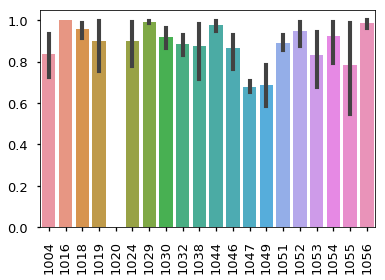

In [1097]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO')

### Structured Tasks

In [945]:
DataStr=pd.DataFrame()
tasks= ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
for t in tasks: 
    DataStr=pd.concat((DataStr,Data[Data.Task==t]))

In [946]:
Data = DataStr.copy()

In [947]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [948]:
Data=Data[Data.Subject!=1020] #subj does not have scores for 0-5

In [949]:
Data.Task.unique()

array(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'], dtype=object)

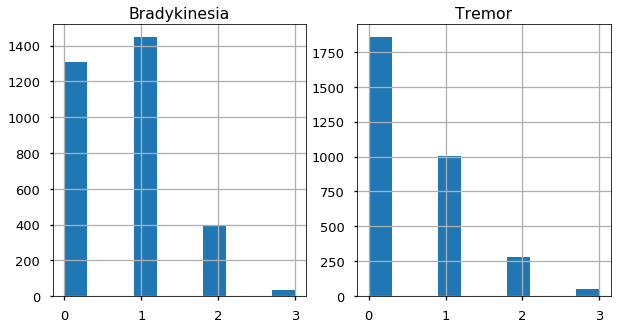

In [950]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x2b53a8390>, <matplotlib.text.Text at 0x14b9a9470>)

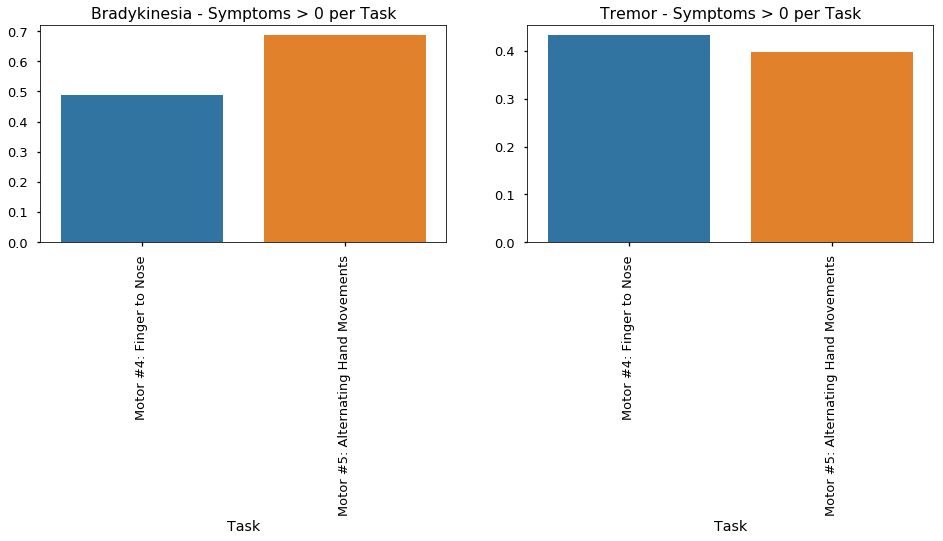

In [951]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

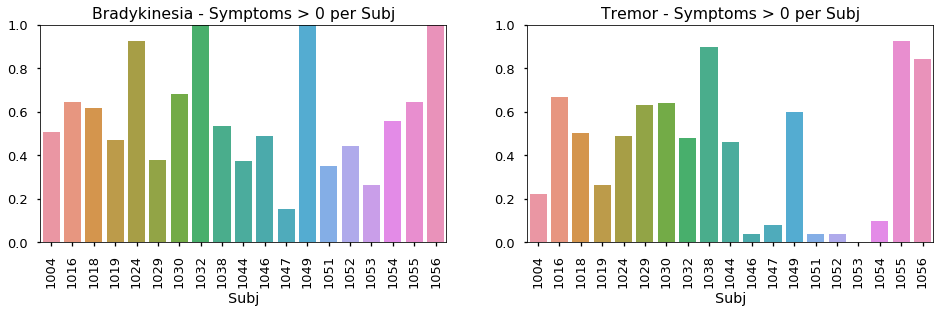

In [898]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

In [952]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

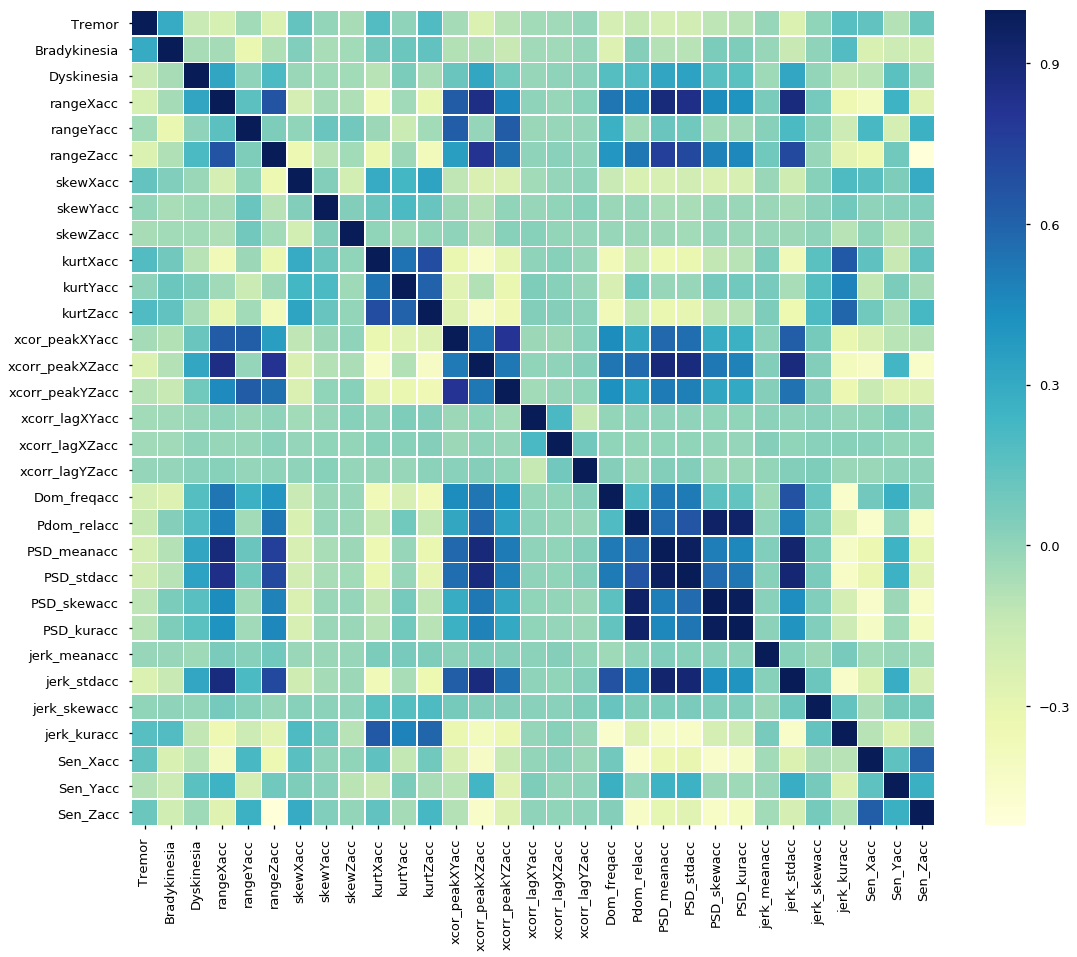

In [953]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

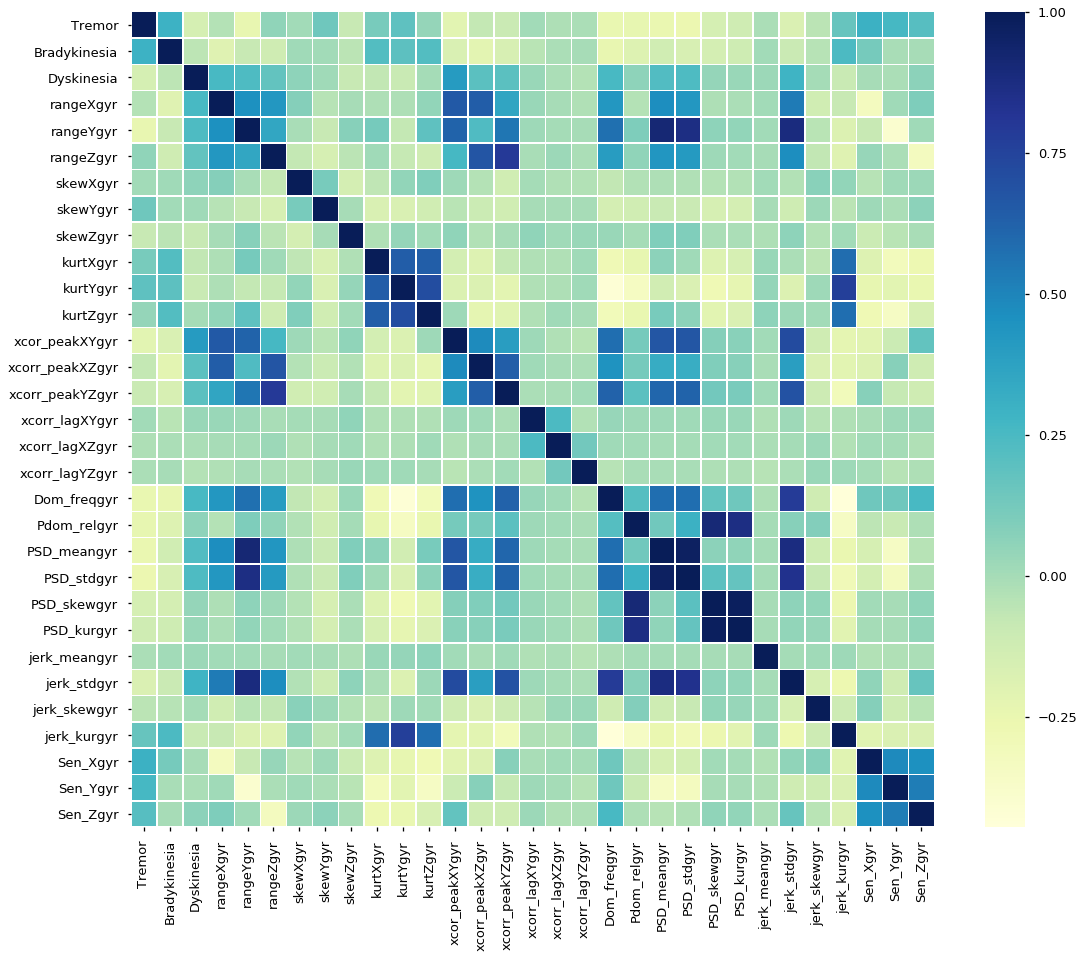

In [954]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## Structured vs Functional tasks

### Use accelerometer and gyro features

Train on 1 subject - assess feature importance and number of trees

In [846]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [903]:
print(len(indn),len(indp))
N = min(len(indn),len(indp))
print(N)

1863 3207
1863


In [476]:
#rebalance classes 
indn = np.where(y == 0)[0]
indp = np.where(y > 0)[0]

N = max(len(indn),len(indp)) 
nratio = 1
pratio = 1
Nneg=nratio*N
Npos=pratio*N

indn_new = np.random.choice(indn,Nneg,replace=True)
indp_new = np.random.choice(indp,Npos,replace=True)

#should add noise or jitter clips to obtain new data

In [956]:
t1=time.time()
res_all = pd.DataFrame()

#use all data
X = Data.iloc[:,7:].as_matrix()

#standardize features (should be done in the CV loop)
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns

for symptom in ['Bradykinesia']:

    #use all data
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    groups = Data.Subject.as_matrix()

#     #balance classes
#     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
#     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
#     y=(y>0).values.astype(int)
#     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']
    
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2),GradientBoostingClassifier(c)]
              #SVC(cache_size=800,probability=True)]          
#           XGBClassifier()]
    model_name = ['Random Forest','GB']#,'SVM']#,'XGB']
    models = list(zip(models,model_name))
    
    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1877/3207 = 0.59
Training Random Forest

Subj/Visit 0, prec=0.580, rec=0.323, Spec=0.761, auroc_train=1.000, auroc=0.572

Subj/Visit 1, prec=0.632, rec=0.883, Spec=0.070, auroc_train=1.000, auroc=0.404

Subj/Visit 2, prec=0.698, rec=0.970, Spec=0.323, auroc_train=1.000, auroc=0.816

Subj/Visit 3, prec=0.703, rec=0.887, Spec=0.667, auroc_train=1.000, auroc=0.862

Subj/Visit 4, prec=0.967, rec=0.780, Spec=0.667, auroc_train=1.000, auroc=0.845

Subj/Visit 5, prec=0.465, rec=0.828, Spec=0.425, auroc_train=1.000, auroc=0.609

Subj/Visit 6, prec=0.784, rec=0.901, Spec=0.474, auroc_train=1.000, auroc=0.774
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.580, rec=0.860, Spec=0.284, auroc_train=1.000, auroc=0.587

Subj/Visit 9, prec=0.442, rec=1.000, Spec=0.248, auroc_train=1.000, auroc=0.694

Subj/Visit 10, prec=0.619, rec=0.833, Spec=0.512, auroc_train=1.000, auroc=0.772

Subj/Visit 11, prec=0.356, rec=0.913, Spec=0.705, auroc_train=1.000, auroc=0.881
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.650, rec=0.236, Spec=0.931, auroc_train=1.000, auroc=0.748

Subj/Visit 14, prec=0.782, rec=0.897, Spec=0.802, auroc_train=1.000, auroc=0.844

Subj/Visit 15, prec=0.214, rec=0.500, Spec=0.340, auroc_train=1.000, auroc=0.380

Subj/Visit 16, prec=0.841, rec=0.829, Spec=0.804, auroc_train=1.000, auroc=0.904

Subj/Visit 17, prec=0.902, rec=0.435, Spec=0.915, auroc_train=1.000, auroc=0.690
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.721, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.700+/-0.196, prec=0.696+/-0.222, rec=0.778+/-0.225, auprc=0.725+/-0.216
Training GB


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.621, rec=0.456, Spec=0.716, auroc_train=0.980, auroc=0.626

Subj/Visit 1, prec=0.621, rec=0.874, Spec=0.035, auroc_train=0.979, auroc=0.223

Subj/Visit 2, prec=0.722, rec=0.960, Spec=0.403, auroc_train=0.975, auroc=0.822

Subj/Visit 3, prec=0.594, rec=0.787, Spec=0.522, auroc_train=0.978, auroc=0.800

Subj/Visit 4, prec=0.966, rec=0.767, Spec=0.667, auroc_train=0.973, auroc=0.776

Subj/Visit 5, prec=0.446, rec=0.844, Spec=0.368, auroc_train=0.976, auroc=0.594

Subj/Visit 6, prec=0.779, rec=0.876, Spec=0.474, auroc_train=0.978, auroc=0.773
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=0.974, auroc=nan

Subj/Visit 8, prec=0.536, rec=0.796, Spec=0.210, auroc_train=0.978, auroc=0.481

Subj/Visit 9, prec=0.407, rec=0.938, Spec=0.183, auroc_train=0.971, auroc=0.606

Subj/Visit 10, prec=0.675, rec=0.718, Spec=0.671, auroc_train=0.976, auroc=0.736

Subj/Visit 11, prec=0.328, rec=0.957, Spec=0.651, auroc_tr

In [957]:
le = LabelEncoder()
# aurocall = res_group['Random Forest']['auroc']
# aurocall = res_group['GB']['auroc']
subj = le.fit_transform(np.unique(groups))

In [958]:
res_group['Random Forest'].keys()

dict_keys(['fi', 'auroc', 'f1', 'auprc', 'fpr', 'spec', 'tpr', 'rec'])

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


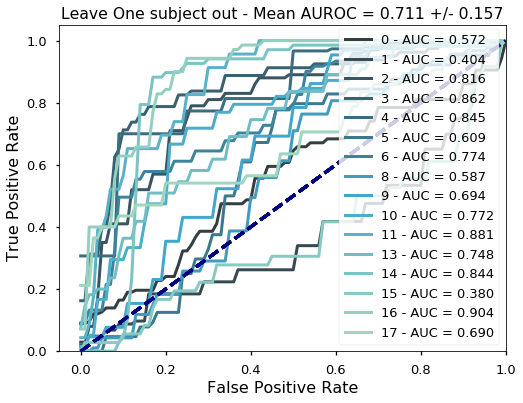

In [964]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(res_group['Random Forest']['tpr'])):
    if len(res_group['Random Forest']['tpr'][v]) == 0:
        continue
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],res_group['Random Forest']['auroc'][v],
                ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

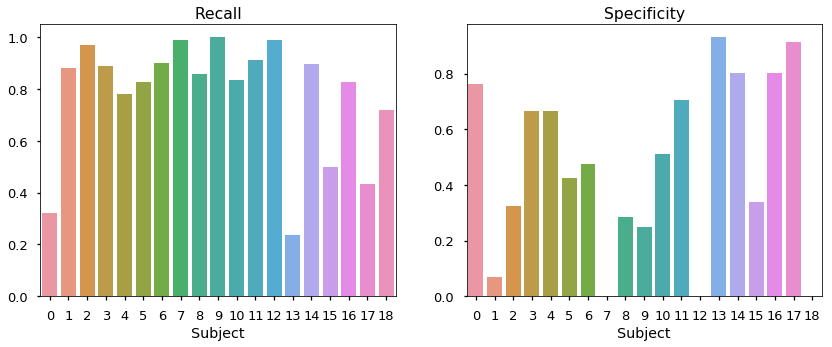

In [960]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['rec'])
plt.title('Recall')
plt.xlabel('Subject')
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['spec'])
plt.title('Specificity')
plt.xlabel('Subject')

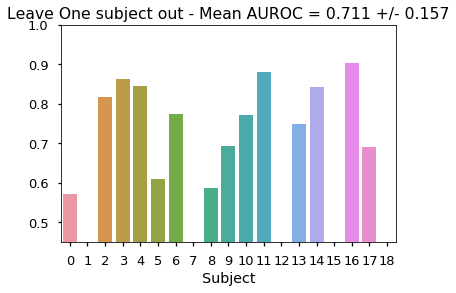

In [962]:
sns.set_context('talk')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['Random Forest']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

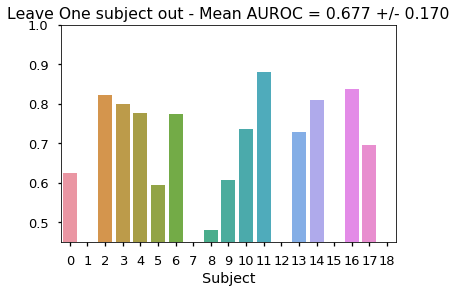

In [966]:
sns.set_context('talk')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['GB']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Feature importance

In [922]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

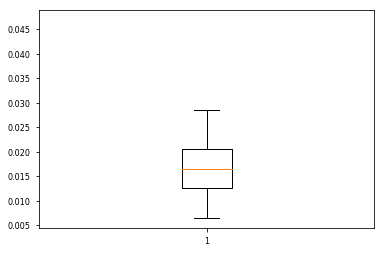

In [931]:
ax=plt.boxplot(meanfi)

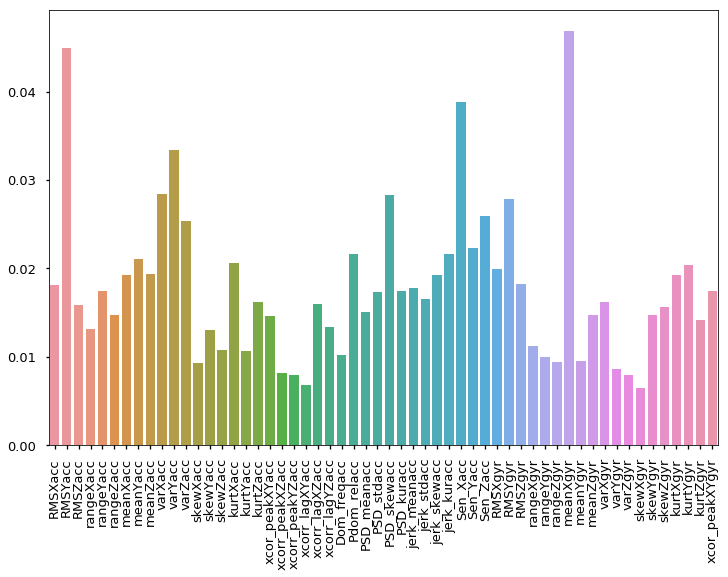

In [939]:
plt.figure(figsize=(12,8))
sns.barplot(x=np.arange(len(rf.feature_importances_)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(rf.feature_importances_)),fnames,rotation=90)

In [925]:
np.percentile(meanfi,75)

0.020469610798760085

In [926]:
sum(meanfi>0.02)

15

In [938]:
#top 14 features
fnames.values[np.argsort(meanfi)[::-1]][:14]

array(['meanXgyr', 'RMSYacc', 'Sen_Xacc', 'varYacc', 'varXacc',
       'PSD_skewacc', 'RMSYgyr', 'Sen_Zacc', 'varZacc', 'Sen_Yacc',
       'jerk_kuracc', 'Pdom_relacc', 'meanYacc', 'kurtXacc'], dtype=object)

In [937]:
fnames.values[np.argsort(meanfi)[::-1]][:n]

array(['meanXgyr', 'RMSYacc', 'Sen_Xacc', 'varYacc', 'varXacc',
       'PSD_skewacc', 'RMSYgyr', 'Sen_Zacc', 'varZacc', 'Sen_Yacc',
       'jerk_kuracc', 'Pdom_relacc', 'meanYacc', 'kurtXacc'], dtype=object)

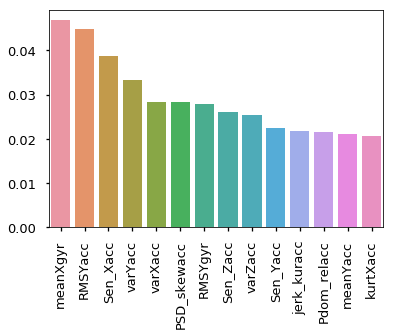

In [936]:
n = 14
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames.values[np.argsort(meanfi)[::-1]][:n],rotation=90)

### Feature selection - Retrain on top 14 features

In [929]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    groups = Data.Subject.as_matrix()

#     #balance classes
#     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
#     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
#     y=(y>0).values.astype(int)
#     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

    #top features
    topf = fnames.values[np.argsort(meanfi)[::-1]][:14]
#     topf = fnames.values[:14]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()
    y = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1)[symptom]
    y=(y>0).values.astype(int)
    
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
    print(X.shape)

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    
    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1877/3207 = 0.59
(3207, 14)
Training Random Forest

Subj/Visit 0, prec=0.817, rec=0.310, Spec=0.929, auroc_train=1.000, auroc=0.667

Subj/Visit 1, prec=0.615, rec=0.854, Spec=0.035, auroc_train=1.000, auroc=0.232

Subj/Visit 2, prec=0.678, rec=0.970, Spec=0.258, auroc_train=1.000, auroc=0.717

Subj/Visit 3, prec=0.741, rec=0.787, Spec=0.756, auroc_train=1.000, auroc=0.844

Subj/Visit 4, prec=0.929, rec=0.953, Spec=0.083, auroc_train=1.000, auroc=0.786

Subj/Visit 5, prec=0.587, rec=0.844, Spec=0.642, auroc_train=1.000, auroc=0.767

Subj/Visit 6, prec=0.786, rec=0.851, Spec=0.509, auroc_train=1.000, auroc=0.800
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.612, rec=0.763, Spec=0.444, auroc_train=1.000, auroc=0.657

Subj/Visit 9, prec=0.471, rec=1.000, Spec=0.330, auroc_train=1.000, auroc=0.684

Subj/Visit 10, prec=0.656, rec=0.756, Spec=0.622, auroc_train=1.000, auroc=0.775

Subj/Visit 11, prec=0.207, rec=1.000, Spec=0.318, auroc_train=1.000, auroc=0.881
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.995, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.733, rec=0.400, Spec=0.921, auroc_train=1.000, auroc=0.740

Subj/Visit 14, prec=0.779, rec=0.882, Spec=0.802, auroc_train=1.000, auroc=0.882

Subj/Visit 15, prec=0.228, rec=0.500, Spec=0.390, auroc_train=1.000, auroc=0.441

Subj/Visit 16, prec=0.714, rec=0.786, Spec=0.607, auroc_train=1.000, auroc=0.798

Subj/Visit 17, prec=0.836, rec=0.541, Spec=0.809, auroc_train=1.000, auroc=0.699
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.786, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.709+/-0.190, prec=0.705+/-0.220, rec=0.788+/-0.202, auprc=0.733+/-0.198
Elapsed time = 0.324 min


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


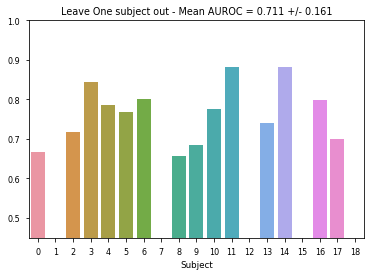

In [930]:
sns.set_context('paper')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['Random Forest']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [585]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


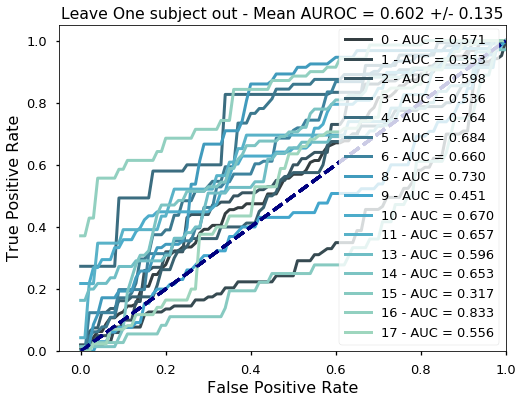

In [586]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(res_group['Random Forest']['tpr'])):
    if len(res_group['Random Forest']['tpr'][v]) == 0:
        continue
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

(0.45, 1.0)

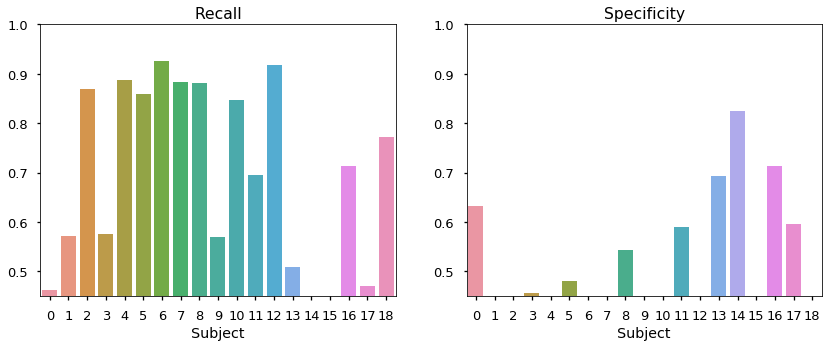

In [587]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['rec'])
plt.title('Recall')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['spec'])
plt.title('Specificity')
plt.xlabel('Subject')
plt.ylim([0.45,1.])

(0.45, 1.0)

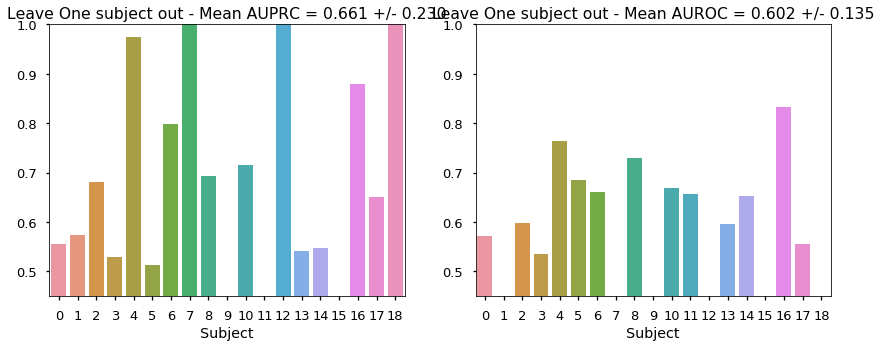

In [588]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['auprc'])
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.nanmean(auprcall),np.nanstd(auprcall)))
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['auroc'])
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.ylim([0.45,1.])

## K-fold CV

In [597]:
t1=time.time()

for symptom in ['Bradykinesia']:
    
    X = Data.iloc[:,7:].as_matrix()
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Bradykinesia 1863/3193 = 0.58
Random Forest
f1_train=1.000+/-0.000, f1_test=0.916+/-0.007, prec=0.898+/-0.014, rec=0.935+/-0.012, auprc=0.966+/-0.008
[[226  40]
 [ 29 343]]
Elapsed time = 6.000


In [598]:
auc_fold_clf

[[0.96881999804943464,
  0.95768562255587053,
  0.96005231933388369,
  0.98061336025122392,
  0.96531905058562661]]

### LOSOCV

In [106]:
#LOSOCV
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
# X_std = StandardScaler().fit_transform(X)
# X_std = X.as_matrix()

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1971/3485 = 0.57
Training Random Forest

Subj/Visit 0, prec=0.527, rec=0.239, Spec=0.780, auroc_train=1.000, auroc=0.484

Subj/Visit 1, prec=0.650, rec=0.697, Spec=0.305, auroc_train=1.000, auroc=0.434

Subj/Visit 2, prec=0.674, rec=0.861, Spec=0.297, auroc_train=1.000, auroc=0.623

Subj/Visit 3, prec=0.719, rec=0.852, Spec=0.710, auroc_train=1.000, auroc=0.871

Subj/Visit 4, prec=0.037, rec=0.667, Spec=0.235, auroc_train=1.000, auroc=0.483

Subj/Visit 5, prec=0.959, rec=0.886, Spec=0.500, auroc_train=1.000, auroc=0.713

Subj/Visit 6, prec=0.467, rec=0.632, Spec=0.546, auroc_train=1.000, auroc=0.597

Subj/Visit 7, prec=0.748, rec=0.928, Spec=0.339, auroc_train=1.000, auroc=0.789
only 1 class in test data - cannot compute roc curve

Subj/Visit 8, prec=1.000, rec=0.911, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 9, prec=0.573, rec=0.781, Spec=0.341, auroc_train=1.000, auroc=0.526

Subj/Visit 10, prec=0.433, rec=0.897, Spec=0.310, auroc_train=1.000, auroc=0.588

In [104]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

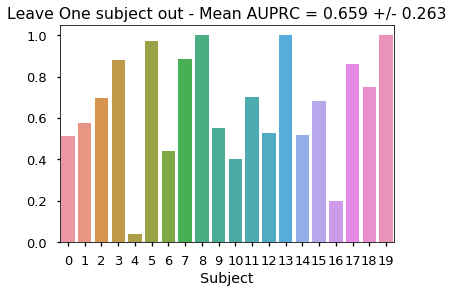

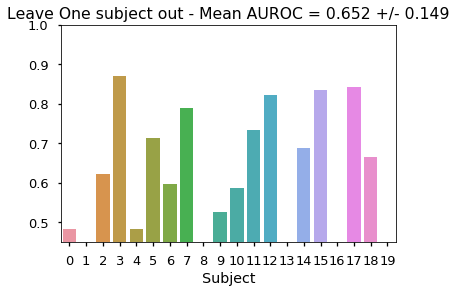

In [105]:
# plt.figure()
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
# plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.nanmean(auprcall),np.nanstd(auprcall)))
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

Tremor

In [59]:
#LOSOCV
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
# X_std = StandardScaler().fit_transform(X)

for symptom in ['Tremor']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 1388/3343 = 0.42
Training Random Forest

Subj/Visit 0, prec=0.531, rec=0.366, Spec=0.908, auroc=0.696

Subj/Visit 1, prec=0.656, rec=0.357, Spec=0.625, auroc=0.518

Subj/Visit 2, prec=0.734, rec=0.547, Spec=0.802, auroc=0.765

Subj/Visit 3, prec=0.412, rec=0.609, Spec=0.688, auroc=0.722

Subj/Visit 4, prec=0.841, rec=0.451, Spec=0.920, auroc=0.691

Subj/Visit 5, prec=0.674, rec=0.527, Spec=0.576, auroc=0.602

Subj/Visit 6, prec=0.929, rec=0.771, Spec=0.894, auroc=0.849

Subj/Visit 7, prec=0.414, rec=0.322, Spec=0.598, auroc=0.454

Subj/Visit 8, prec=0.868, rec=0.485, Spec=0.333, auroc=0.333

Subj/Visit 9, prec=0.846, rec=0.647, Spec=0.899, auroc=0.845

Subj/Visit 10, prec=0.115, rec=0.500, Spec=0.858, auroc=0.820

Subj/Visit 11, prec=0.474, rec=0.750, Spec=0.932, auroc=0.903

Subj/Visit 12, prec=0.754, rec=0.838, Spec=0.584, auroc=0.795

Subj/Visit 13, prec=0.185, rec=0.833, Spec=0.861, auroc=0.924

Subj/Visit 14, prec=0.000, rec=0.000, Spec=0.818, auroc=0.528


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.848, auroc=nan

Subj/Visit 16, prec=0.222, rec=1.000, Spec=0.656, auroc=0.836

Subj/Visit 17, prec=1.000, rec=0.252, Spec=1.000, auroc=0.653

Subj/Visit 18, prec=0.927, rec=0.273, Spec=0.880, auroc=0.719
f1_test=0.463+/-0.227, prec=0.557+/-0.320, rec=0.501+/-0.265, auprc=0.606+/-0.293
Elapsed time = 0.217 min


In [60]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

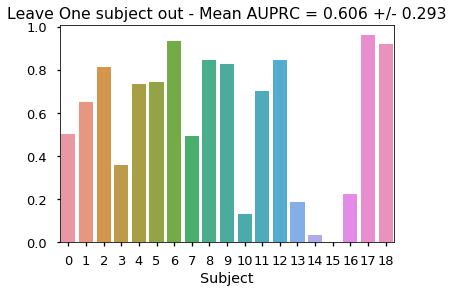

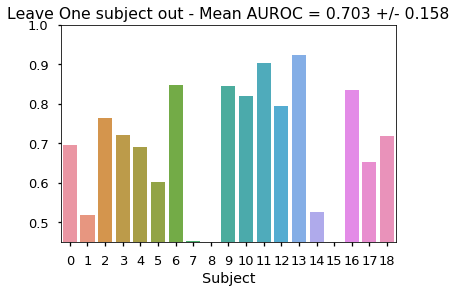

In [61]:
# plt.figure()
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
# plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.nanmean(auprcall),np.nanstd(auprcall)))
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

### Personal models

In [62]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.865, Spec=nan, auroc=nan

Subj/Visit 1, prec=0.077, rec=0.083, Spec=0.667, auroc=0.603

Subj/Visit 2, prec=0.583, rec=0.583, Spec=0.853, auroc=0.828

Subj/Visit 3, prec=0.595, rec=0.846, Spec=0.423, auroc=0.784

Subj/Visit 4, prec=0.476, rec=0.769, Spec=0.718, auroc=0.793

Subj/Visit 5, prec=0.643, rec=0.750, Spec=0.583, auroc=0.781
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.792, Spec=nan, auroc=nan
f1_test=0.636+/-0.259, prec=0.625+/-0.294, rec=0.670+/-0.254, auprc=0.687+/-0.275
Subject 1016
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.792, Spec=nan, auroc=nan

Subj/Visit 1, prec=0.400, rec=1.000, Spec=0.500, auroc=0.782

Subj/Visit 2, prec=0.455, rec=1.000, Spec=0.647, auroc=0.988
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000,

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice



Subj/Visit 1, prec=1.000, rec=0.800, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.500, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.917, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.667, Spec=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.786, Spec=1.000, auroc=1.000
f1_test=0.747+/-0.318, prec=0.792+/-0.359, rec=0.738+/-0.322, auprc=0.900+/-0.224
Subject 1030
Training Random Forest

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=0.625, rec=0.833, Spec=0.500, auroc=0.649

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=0.619, rec=0.929, Spec=0.429, auroc=0.653

Subj/Visit 6, prec=0.875, rec=0.955, Spec=0.625, auroc=0.983
f1_test=0.910+/-0.119, prec=0.874+/-0.165, rec=0.959+/-0.058, auprc=0.897+/-0.161
Subject 1032
Training Random Forest
only 1 class available in train

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.292, Spec=nan, auroc=nan

Subj/Visit 1, prec=1.000, rec=0.571, Spec=1.000, auroc=0.964

Subj/Visit 2, prec=1.000, rec=0.643, Spec=1.000, auroc=0.972

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc=0.969

Subj/Visit 4, prec=0.538, rec=1.000, Spec=0.700, auroc=0.957

Subj/Visit 5, prec=0.923, rec=1.000, Spec=0.917, auroc=1.000

Subj/Visit 6, prec=0.650, rec=1.000, Spec=0.462, auroc=0.849
f1_test=0.744+/-0.142, prec=0.825+/-0.185, rec=0.787+/-0.266, auprc=0.946+/-0.059
Subject 1044
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.769, Spec=1.000, auroc=0.976


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.750, auroc=nan

Subj/Visit 2, prec=1.000, rec=0.857, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.867, Spec=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=0.750, rec=0.857, Spec=0.895, auroc=0.947

Subj/Visit 6, prec=1.000, rec=0.500, Spec=1.000, auroc=0.992
f1_test=0.741+/-0.318, prec=0.821+/-0.346, rec=0.693+/-0.317, auprc=0.976+/-0.043
Subject 1046
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.900, Spec=1.000, auroc=0.996

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.556, Spec=1.000, auroc=0.977

Subj/Visit 4, prec=0.750, rec=0.429, Spec=0.947, auroc=0.891

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.706, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.4

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.700, rec=0.538, Spec=0.769, auroc=0.766

Subj/Visit 1, prec=0.800, rec=1.000, Spec=0.938, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.667, Spec=1.000, auroc=0.963

Subj/Visit 3, prec=1.000, rec=0.500, Spec=1.000, auroc=0.837

Subj/Visit 4, prec=0.545, rec=1.000, Spec=0.688, auroc=0.859

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.167, Spec=1.000, auroc=0.941
f1_test=0.708+/-0.213, prec=0.864+/-0.172, rec=0.696+/-0.298, auprc=0.876+/-0.121
Subject 1052
Training Random Forest

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.917, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.812, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=0.700, rec=1.000, Spec=0.880, auroc=0.949
f1_test=0.946+/-0.066, prec=0.950+/-0.112, rec=0.955+/-0.071, auprc=0.953+/-

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.818, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.864, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.667, Spec=1.000, auroc=0.972


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.875, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.818, auroc=nan
f1_test=0.151+/-0.293, prec=0.333+/-0.471, rec=0.120+/-0.245, auprc=0.959+/-0.033
Subject 1054
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc=nan

Subj/Visit 1, prec=1.000, rec=0.917, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=0.750, rec=0.882, Spec=0.000, auroc=0.453

Subj/Visit 4, prec=0.909, rec=0.833, Spec=0.917, auroc=0.965

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.667, auroc=0.861
f1_test=0.884+/-0.119, prec=0.860+/-0.184, rec=0.939+/-0.066, auprc=0.876+/-0.186
Subject 1055
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.375, Spec=nan, auroc=nan

Subj/

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice


In [63]:
subj=le.fit_transform(res_all.index.values)

Results by subject averaged over 6 visits

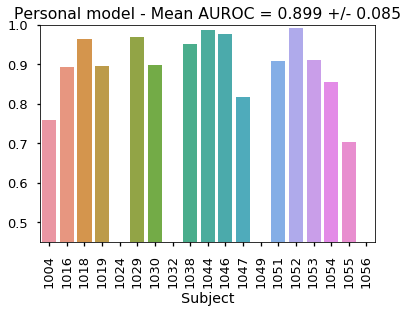

In [64]:
# ax=sns.barplot(x=subj,y=res_all.auroc.values)
# plt.title('AUPRC')
# plt.xlabel('Subject')
# plt.ylim([0.45,1.])
# plt.title('Personal model - Mean AUPRC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))
# ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)

ax=sns.barplot(x=subj,y=res_all.auroc.values)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Personal model - Mean AUROC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))
ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)

# All tasks

## LOSO CV

In [109]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16874/41218 = 0.41
Training Random Forest

Subj/Visit 0, prec=0.461, rec=0.450, Spec=0.813, auroc=0.753

Subj/Visit 1, prec=0.955, rec=0.638, Spec=0.918, auroc=0.923

Subj/Visit 2, prec=0.756, rec=0.707, Spec=0.804, auroc=0.853

Subj/Visit 3, prec=0.482, rec=0.946, Spec=0.694, auroc=0.885

Subj/Visit 4, prec=0.736, rec=0.595, Spec=0.798, auroc=0.799

Subj/Visit 5, prec=0.632, rec=0.590, Spec=0.681, auroc=0.705

Subj/Visit 6, prec=0.648, rec=0.727, Spec=0.757, auroc=0.841

Subj/Visit 7, prec=0.845, rec=0.425, Spec=0.796, auroc=0.804

Subj/Visit 8, prec=0.301, rec=0.495, Spec=0.671, auroc=0.657

Subj/Visit 9, prec=0.664, rec=0.684, Spec=0.774, auroc=0.820

Subj/Visit 10, prec=0.575, rec=0.409, Spec=0.850, auroc=0.772

Subj/Visit 11, prec=0.200, rec=0.615, Spec=0.797, auroc=0.789

Subj/Visit 12, prec=0.556, rec=0.440, Spec=0.725, auroc=0.614

Subj/Visit 13, prec=0.250, rec=0.609, Spec=0.734, auroc=0.770

Subj/Visit 14, prec=0.804, rec=0.556, Spec=0.887, auroc=0.850

Su

In [110]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

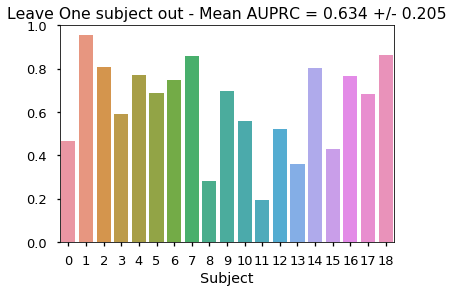

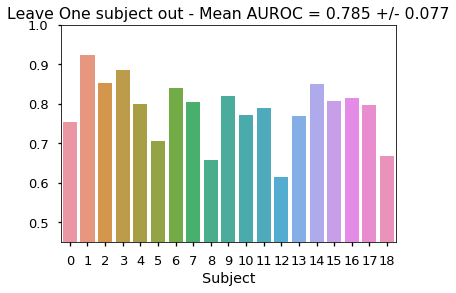

In [45]:
# plt.figure()
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
# plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.mean(auprcall),np.std(auprcall)))
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

### Tremor

In [174]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Tremor']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 6421/28499 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.258, rec=0.142, Spec=0.945, auroc=0.743

Subj/Visit 1, prec=0.667, rec=0.026, Spec=0.986, auroc=0.674

Subj/Visit 2, prec=0.464, rec=0.107, Spec=0.982, auroc=0.805

Subj/Visit 3, prec=0.217, rec=0.533, Spec=0.892, auroc=0.811

Subj/Visit 4, prec=0.457, rec=0.267, Spec=0.904, auroc=0.706

Subj/Visit 5, prec=0.345, rec=0.067, Spec=0.948, auroc=0.605

Subj/Visit 6, prec=0.601, rec=0.214, Spec=0.889, auroc=0.662

Subj/Visit 7, prec=0.731, rec=0.475, Spec=0.981, auroc=0.912

Subj/Visit 8, prec=0.435, rec=0.114, Spec=0.990, auroc=0.768

Subj/Visit 9, prec=0.963, rec=0.248, Spec=0.983, auroc=0.796

Subj/Visit 10, prec=0.550, rec=0.538, Spec=0.970, auroc=0.931

Subj/Visit 11, prec=0.048, rec=0.010, Spec=0.960, auroc=0.321

Subj/Visit 12, prec=0.000, rec=0.000, Spec=0.972, auroc=0.682

Subj/Visit 13, prec=0.810, rec=0.468, Spec=0.920, auroc=0.814

Subj/Visit 14, prec=0.029, rec=0.167, Spec=0.981, auroc=0.941
f1_test=0.

In [192]:
auprcall = res_group['Random Forest']['auprc']
aurocall = auprcall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

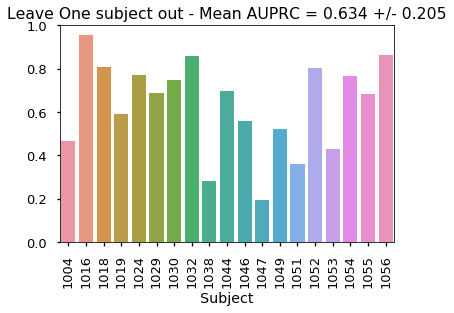

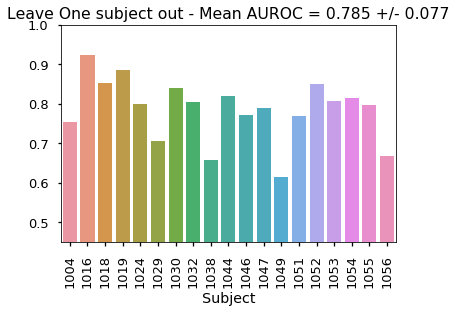

In [112]:
plt.figure()
ax=sns.barplot(x=subj,y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.mean(auprcall),np.std(auprcall)))
plt.figure()
ax=sns.barplot(x=subj,y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))
ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)

## LOSO CV - Full recording

In [132]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1236/3328 = 0.37
Training Random Forest

Subj/Visit 0, prec=0.524, rec=0.500, Spec=0.855, auroc=0.792

Subj/Visit 1, prec=0.889, rec=0.525, Spec=0.867, auroc=0.860

Subj/Visit 2, prec=0.677, rec=0.587, Spec=0.804, auroc=0.785

Subj/Visit 3, prec=0.554, rec=0.837, Spec=0.791, auroc=0.897

Subj/Visit 4, prec=0.745, rec=0.471, Spec=0.853, auroc=0.813

Subj/Visit 5, prec=0.683, rec=0.500, Spec=0.810, auroc=0.753

Subj/Visit 6, prec=0.734, rec=0.681, Spec=0.850, auroc=0.860

Subj/Visit 7, prec=0.836, rec=0.393, Spec=0.862, auroc=0.808

Subj/Visit 8, prec=0.308, rec=0.364, Spec=0.739, auroc=0.681

Subj/Visit 9, prec=0.550, rec=0.493, Spec=0.765, auroc=0.782

Subj/Visit 10, prec=0.632, rec=0.436, Spec=0.890, auroc=0.774

Subj/Visit 11, prec=0.188, rec=0.462, Spec=0.846, auroc=0.828

Subj/Visit 12, prec=0.638, rec=0.446, Spec=0.788, auroc=0.675

Subj/Visit 13, prec=0.359, rec=0.583, Spec=0.842, auroc=0.835

Subj/Visit 14, prec=0.735, rec=0.571, Spec=0.860, auroc=0.845

Subj

In [133]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

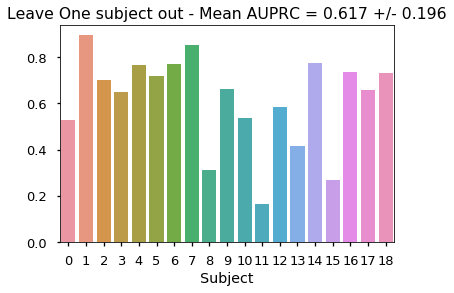

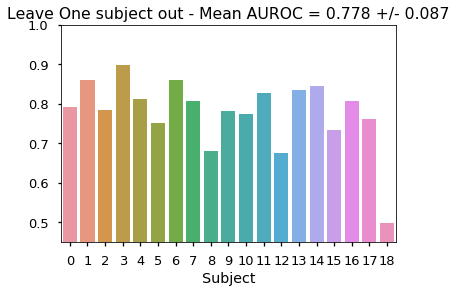

In [134]:
# plt.figure()
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
# plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.mean(auprcall),np.std(auprcall)))
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## Personal models - Leave one visit out

Bradykinesia

In [102]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.790, rec=0.200, Spec=0.847, auroc=0.802

Subj/Visit 1, prec=0.357, rec=0.278, Spec=0.926, auroc=0.686

Subj/Visit 2, prec=0.389, rec=0.583, Spec=0.916, auroc=0.926

Subj/Visit 3, prec=0.713, rec=0.689, Spec=0.880, auroc=0.862

Subj/Visit 4, prec=0.477, rec=0.808, Spec=0.911, auroc=0.944

Subj/Visit 5, prec=0.714, rec=0.543, Spec=0.957, auroc=0.918

Subj/Visit 6, prec=0.613, rec=0.507, Spec=0.900, auroc=0.860
f1_test=0.510+/-0.139, prec=0.579+/-0.159, rec=0.515+/-0.199, auprc=0.584+/-0.211
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.996, rec=0.972, Spec=0.989, auroc=0.997

Subj/Visit 1, prec=0.868, rec=1.000, Spec=0.613, auroc=0.985

Subj/Visit 2, prec=0.908, rec=1.000, Spec=0.760, auroc=0.999

Subj/Visit 3, prec=0.988, rec=0.969, Spec=0.963, auroc=0.994

Subj/Visit 4, prec=0.916, rec=0.996, Spec=0.792, auroc=0.900

Subj/Visit 5, prec=0.939, rec=0.989, Spec=0.805, auroc=0.988

Subj/Visit 6, prec=0.953, rec=0.949, Sp

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.985, auroc=nan

Subj/Visit 3, prec=0.947, rec=0.286, Spec=0.995, auroc=0.901

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=nan
f1_test=0.116+/-0.184, prec=0.241+/-0.385, rec=0.077+/-0.121, auprc=0.716+/-0.053
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.833, rec=0.799, Spec=0.873, auroc=0.930

Subj/Visit 1, prec=0.925, rec=0.861, Spec=0.945, auroc=0.962

Subj/Visit 2, prec=0.911, rec=0.888, Spec=0.927, auroc=0.968

Subj/Visit 3, prec=0.939, rec=0.675, Spec=0.965, auroc=0.961

Subj/Visit 4, prec=0.892, rec=0.859, Spec=0.915, auroc=0.959

Subj/Visit 5, prec=0.864, rec=0.807, Spec=0.897, auroc=0.928

Subj/Visit 6, prec=0.466, rec=0.440, Spec=0.682, auroc=0.584
f1_test=0.794+/-0.144, prec=0.833+/-0.153, rec=0.761+/-0.146, auprc=0.871+/-0.165
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.750, r

In [63]:
subj=le.fit_transform(res_all.index.values)

Results by subject averaged over 6 visits

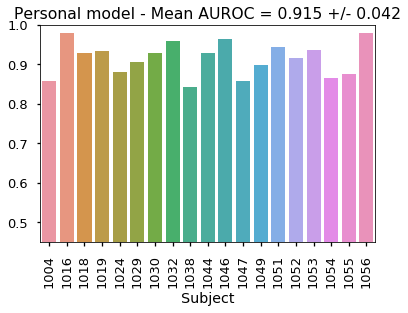

In [64]:
# ax=sns.barplot(x=subj,y=res_all.auroc.values)
# plt.title('AUPRC')
# plt.xlabel('Subject')
# plt.ylim([0.45,1.])
# plt.title('Personal model - Mean AUPRC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))
# ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)

ax=sns.barplot(x=subj,y=res_all.auroc.values)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Personal model - Mean AUROC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))
ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)

In [105]:
res_visit_all[0]

19

Results by visit averaged over subjects

In [99]:
#average tpr across subjs for each visit
tpr_visits = np.array(101,6)
for i in len(res_visit_all):
    for v in len(res_visit_all[i]['Random Forest']['tpr']):
        
        


(101,)

In [84]:
Auroc_visits = pd.DataFrame()
for i in range(len(res_visit_all)):
    d = pd.DataFrame(res_visit_all[i]['Random Forest']['auprc'])
    Auroc_visits=pd.concat((Auroc_visits,d),axis=1)
Auroc_visits.columns=subjs
Auroc_visits

,1004,1016,1018,1019,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056
0,0.846617,0.999105,0.915151,0.668641,0.953136,0.940544,0.914283,0.997427,0.668845,0.952478,0.969275,0.662695,0.898792,0.695684,0.986762,0.598825,0.980361,0.890217,0.988957
1,0.234271,0.992972,0.957370,0.929728,0.929328,0.991585,0.939283,0.987264,0.812331,0.923644,0.975977,NaN,0.940382,0.519678,0.868288,0.699603,0.877692,0.617688,0.994744
2,0.359961,0.999574,0.904097,0.928531,0.913433,0.911258,0.835492,0.973569,0.798119,0.954536,0.980987,NaN,0.960387,0.702637,0.830142,0.922891,0.820564,0.706509,0.978854
3,0.777681,0.998132,0.956216,0.801765,0.921623,0.612202,0.905674,0.998619,0.888662,0.967071,0.961218,0.769536,0.951157,0.831829,0.927103,0.910673,0.893622,0.861680,0.992863
4,0.583059,0.917510,0.978661,0.917352,0.901213,0.989532,0.960941,0.997072,0.827227,0.968814,0.984999,NaN,0.959271,0.974206,0.595943,0.702811,0.751908,0.951672,0.996007
5,0.759126,0.996016,0.809105,0.935800,0.782777,0.986573,0.866548,0.984017,0.821629,0.965476,0.863468,NaN,0.916222,0.624789,0.942612,0.657525,0.969756,0.617027,0.997818
6,0.527406,0.995583,0.756876,0.877073,0.755828,0.891969,0.687760,0.933507,0.324019,0.565867,0.875494,NaN,0.469318,0.689715,NaN,NaN,NaN,NaN,NaN


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


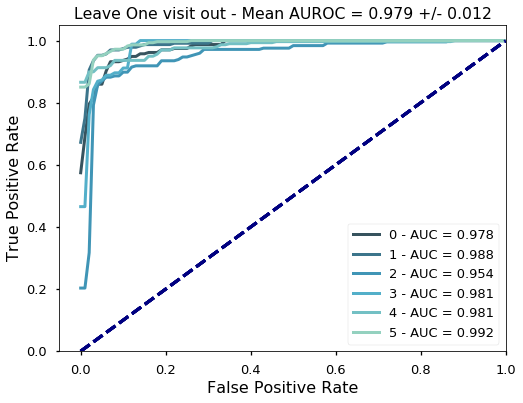

In [50]:
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
current_palette=sns.color_palette("GnBu_d", len(aurocall))
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

In [126]:
# res_all.boxplot()
# plt.title('Personal Models - Results across subjects')

Tremor

There are visit with no positive or negative examples. This makes problematic to compute scores

In [54]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))


Subject 1004
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=0.643


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.996, auroc=nan

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.077, Spec=1.000, auroc=0.986

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.993, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.987, auroc=0.800
f1_test=0.020+/-0.050, prec=0.143+/-0.350, rec=0.011+/-0.027, auprc=0.487+/-0.245
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.882, rec=0.947, Spec=0.900, auroc=0.975

Subj/Visit 1, prec=1.000, rec=0.954, Spec=1.000, auroc=0.999

Subj/Visit 2, prec=0.994, rec=0.952, Spec=0.994, auroc=0.998

Subj/Visit 3, prec=0.969, rec=0.935, Spec=0.971, auroc=0.994

Subj/Visit 4, prec=0.969, rec=0.958, Spec=0.970, auroc=0.991

Subj/Visit 5, prec=1.000, rec=0.944, Spec=1.000, auroc=0.998


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.512, auroc=nan
f1_test=0.821+/-0.336, prec=0.831+/-0.341, rec=0.813+/-0.332, auprc=0.991+/-0.012
Subject 1018
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.108, Spec=1.000, auroc=0.890

Subj/Visit 1, prec=1.000, rec=0.889, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.917, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=0.917, rec=0.297, Spec=0.996, auroc=0.922

Subj/Visit 4, prec=1.000, rec=0.273, Spec=1.000, auroc=0.899

Subj/Visit 5, prec=0.846, rec=0.917, Spec=0.994, auroc=0.997

Subj/Visit 6, prec=0.611, rec=0.786, Spec=0.977, auroc=0.990
f1_test=0.648+/-0.275, prec=0.911+/-0.134, rec=0.598+/-0.329, auprc=0.828+/-0.150
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=0.546

Subj/Visit 1, prec=1.000, rec=0.833, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.984, auroc=0.709

Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc=0.999

Subj/Visit 5, prec=1.000, rec=0.667, Spec=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=0.760
f1_test=0.517+/-0.451, prec=0.571+/-0.495, rec=0.476+/-0.422, auprc=0.630+/-0.420
Subject 1024
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.157, Spec=1.000, auroc=0.884

Subj/Visit 1, prec=0.342, rec=0.394, Spec=0.908, auroc=0.882

Subj/Visit 2, prec=0.113, rec=0.857, Spec=0.837, auroc=0.884

Subj/Visit 3, prec=0.864, rec=0.222, Spec=0.969, auroc=0.789

Subj/Visit 4, prec=0.500, rec=0.353, Spec=0.954, auroc=0.843

Subj/Visit 5, prec=0.085, rec=0.667, Spec=0.856, auroc=0.815

Subj/Visit 6, prec=0.433, rec=0.481, Spec=0.875, auroc=0.854
f1_test=0.316+/-0.104, prec=0.477+/-0.323, rec=0.447+/-0.228, auprc=0.481+/-0.291
Subject 1029
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.381, Spec=1.000, auroc=0.902

Subj/Visit 1, prec=0.336, rec=0.955, Spec=0.704, auroc=0.883

Subj/Visit 2, prec=0.246, rec=0.878, Spec=0.594, auroc=0.730

Subj/Visit 3, prec=0.926, rec=0.565, Spec=0.950, auroc=0.859

Subj/Visit 4, prec=

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=0.998

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc=0.890

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.767+/-0.148
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.933, rec=0.767, Spec=0.926, auroc=0.912

Subj/Visit 1, prec=0.881, rec=0.869, Spec=0.915, auroc=0.948

Subj/Visit 2, prec=0.846, rec=0.881, Spec=0.891, auroc=0.968

Subj/Visit 3, prec=0.879, rec=0.509, Spec=0.967, auroc=0.935

Subj/Visit 4, prec=0.868, rec=0.934, Spec=0.941, auroc=0.973

Subj/Visit 5, prec=0.832, rec=0.779, Spec=0.887, auroc=0.910

Subj/Visit 6, prec=0.833, rec=0.526, Spec=0.907, auroc=0.818
f1_test=0.796+/-0.100, prec=0.868+/-0.033, rec=0.752+/-0.158, auprc=0.910+/-0.047
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 1, prec=0.000, r

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=1.000, rec=0.051, Spec=1.000, auroc=0.779


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.994, auroc=nan

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.989, auroc=0.843


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.994, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc=nan
f1_test=0.016+/-0.036, prec=0.167+/-0.373, rec=0.009+/-0.019, auprc=0.445+/-0.151
Subject 1053
Training Random Forest
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan
Subject 1054
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan
Subject 1055
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.911, rec=0.940, Spec=0.042, auroc=0.444

Subj/Visit 1, prec=0.581, rec=0.891, Spec=0.125, auroc=0.553

Subj/Visit 2, prec=0.664, rec=0.950, Spec=0.187, auroc=0.660

Subj/Visit 3, prec=0.906, rec=0.898, Spec=0.425, auroc=0.822

Subj/Visit 4, prec=0.808, rec=0.978, Spec=0.235, auroc=0.778

Subj/Visit 5, prec=0.977, rec=0.827, Spec=0.583, auroc=0.844
f1_test=0.849+/-0.080, prec=0.808+/-0.142, rec=0.914+/-0.049, auprc=0.873+/-0.118
Subject 1056
Training Random Forest

Subj/Visit 0, prec=0.927, rec=0.862, Spec=0.462, auroc=0.732

Subj/Visit 1, prec=0.428, rec=0.909, Spec=0.303, auroc=0.739

Subj/Visit 2, prec=0.339, rec=0.931, Spec=0.236, auroc=0.676

Subj/Visit 3, prec=0.954, rec=0.912, Spec=0.462, auroc=0.845

Subj/Visit 4, prec=0.959, rec=0.954, Spec=0.125, auroc=0.683

Subj/Visit 5, prec=0.866, rec=0.933, Spec=0.151, auroc=0.656
f1_test=0.793+/-0.182, prec=0.746+/-0.259, rec=0.917+/-0.029, auprc=0.813+/-0.219


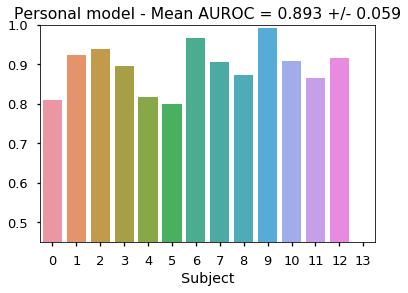

In [30]:
ax=sns.barplot(x=subj,y=res_all.auroc.values)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Personal model - Mean AUROC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))

In [37]:
res_group['Random Forest']['auroc']

[nan, nan, nan, nan, nan, nan]

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


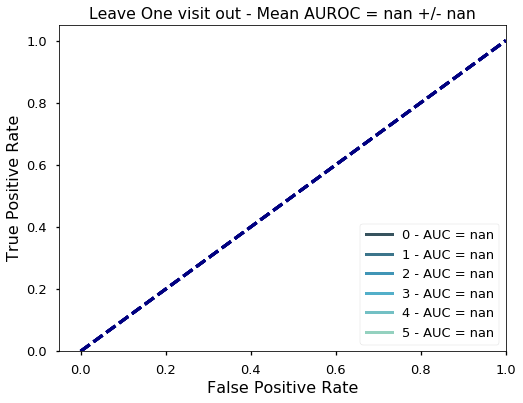

In [31]:
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
current_palette=sns.color_palette("GnBu_d", len(aurocall))
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## Personal models - Leave one visit in
Train on 1 Session data - Test on remaining 

In [106]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.202, rec=0.973, Spec=0.208, auroc=0.595

Subj/Visit 1, prec=0.427, rec=0.093, Spec=0.951, auroc=0.670

Subj/Visit 2, prec=0.641, rec=0.079, Spec=0.982, auroc=0.649

Subj/Visit 3, prec=0.496, rec=0.303, Spec=0.895, auroc=0.762

Subj/Visit 4, prec=0.735, rec=0.070, Spec=0.990, auroc=0.579

Subj/Visit 5, prec=0.529, rec=0.308, Spec=0.895, auroc=0.677

Subj/Visit 6, prec=0.433, rec=0.385, Spec=0.816, auroc=0.662
f1_test=0.276+/-0.119, prec=0.495+/-0.158, rec=0.316+/-0.294, auprc=0.403+/-0.075
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.848, rec=0.974, Spec=0.531, auroc=0.861

Subj/Visit 1, prec=0.904, rec=0.927, Spec=0.731, auroc=0.913

Subj/Visit 2, prec=0.899, rec=0.919, Spec=0.715, auroc=0.933

Subj/Visit 3, prec=0.851, rec=0.982, Spec=0.547, auroc=0.867

Subj/Visit 4, prec=0.879, rec=0.914, Spec=0.649, auroc=0.912

Subj/Visit 5, prec=0.910, rec=0.962, Spec=0.745, auroc=0.940

Subj/Visit 6, prec=0.871, rec=0.959, Sp

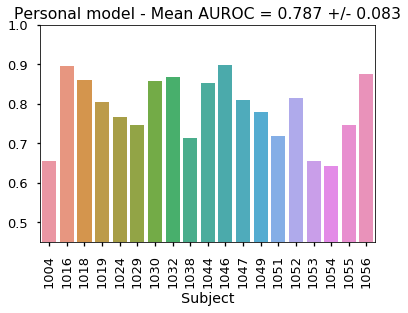

In [108]:
subj=le.fit_transform(res_all.index.values)
ax=sns.barplot(x=subj,y=res_all.auroc.values)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Personal model - Mean AUROC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))
ax=plt.xticks(np.arange(len(subj)),subjs,rotation=90)

In [26]:
res_group['Random Forest']['auroc']

[0.81895606364678908,
 0.66859951845906895,
 0.63628416072311278,
 0.82892598373331805,
 0.59081637878063775,
 0.68880617590295001,
 0.74188822751322758]

Results by visit averaged over subjects

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


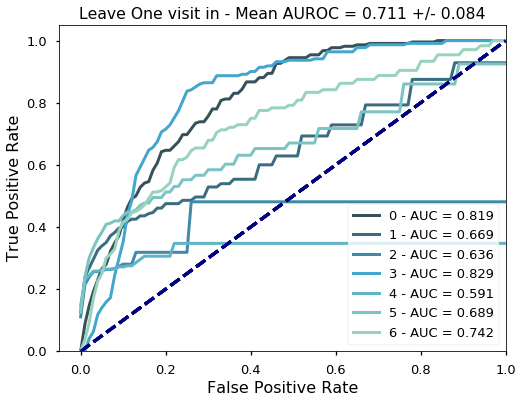

In [27]:
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
current_palette=sns.color_palette("GnBu_d", len(aurocall))
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit in - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## Try with k-fold CV

In [98]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Random Forest
f1_train=1.000+/-0.000, f1_test=0.556+/-0.008, prec=0.843+/-0.016, rec=0.415+/-0.010, auprc=0.736+/-0.005
[[4294  121]
 [ 743  541]]
XGB
f1_train=0.468+/-0.006, f1_test=0.447+/-0.015, prec=0.758+/-0.010, rec=0.317+/-0.014, auprc=0.637+/-0.005
[[4279  136]
 [ 843  441]]
Rows w Bradykinesia 13734/28499 = 0.48
Random Forest
f1_train=1.000+/-0.000, f1_test=0.758+/-0.005, prec=0.773+/-0.004, rec=0.743+/-0.008, auprc=0.850+/-0.003
[[2338  615]
 [ 731 2015]]
XGB
f1_train=0.721+/-0.002, f1_test=0.703+/-0.009, prec=0.693+/-0.008, rec=0.714+/-0.011, auprc=0.758+/-0.008
[[2040  913]
 [ 823 1923]]


In [109]:
t1=time.time()
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('\nRows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=True)

print('Elapsed time = %.3f'%(round(time.time()-t1)))


Rows w Tremor 6421/28499 = 0.23
Npos = 5137, Nneg = 5137
Random Forest
f1_train=1.000+/-0.000, f1_test=0.613+/-0.007, prec=0.505+/-0.010, rec=0.781+/-0.010, auprc=0.698+/-0.009
[[3401 1014]
 [ 291  993]]
Npos = 5137, Nneg = 5137
XGB
f1_train=0.784+/-0.004, f1_test=0.570+/-0.010, prec=0.458+/-0.010, rec=0.755+/-0.017, auprc=0.627+/-0.006
[[3259 1156]
 [ 302  982]]

Rows w Bradykinesia 13734/28499 = 0.48
Npos = 10988, Nneg = 10988
Random Forest
f1_train=1.000+/-0.000, f1_test=0.763+/-0.009, prec=0.758+/-0.009, rec=0.767+/-0.010, auprc=0.848+/-0.005
[[2245  708]
 [ 672 2074]]
Npos = 10988, Nneg = 10988
XGB
f1_train=0.735+/-0.001, f1_test=0.707+/-0.009, prec=0.678+/-0.008, rec=0.739+/-0.012, auprc=0.757+/-0.009
[[1941 1012]
 [ 767 1979]]
Elapsed time = 131.000
